# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

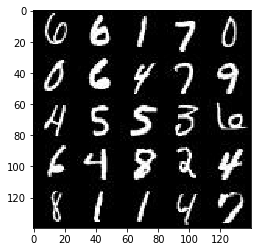

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

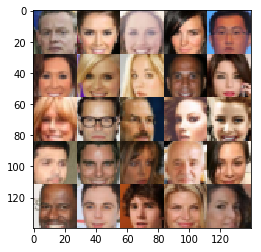

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        h1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        h1 = tf.layers.batch_normalization(h1, training = True)
        h1 = tf.maximum(0.07*h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides = 1, padding ='same')
        h2 = tf.layers.batch_normalization(h2, training = True)
        h2 = tf.maximum(0.07*h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides = 2, padding = 'same')
        h3 = tf.layers.batch_normalization(h3, training = True)
        h3 = tf.maximum(0.07*h3, h3)
        
        flatten = tf.reshape(h3, (-1, 7*7*256))
        dropout_layer = tf.layers.dropout(inputs=flatten, rate=0.5)
        logits = tf.layers.dense(dropout_layer, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):    
        x1 = tf.layers.dense(z, 7*7*512, activation= None)
        
        h2 = tf.reshape(x1, (-1, 7, 7, 512))
        h2 = tf.layers.batch_normalization(h2, training = is_train)
        h2 = tf.maximum(0.07*h2, h2)
        
        h5 = tf.layers.conv2d_transpose(h2, 256, 5, strides = 1, padding = 'same')
        h5 = tf.layers.batch_normalization(h5, training = is_train)
        h5 = tf.maximum(0.07*h5, h5)
        
        h3 = tf.layers.conv2d_transpose(h5, 128, 5, strides = 1, padding = 'same')
        h3 = tf.layers.batch_normalization(h3, training = is_train)
        h3 = tf.maximum(0.07*h3, h3)
        
        h4 = tf.layers.conv2d_transpose(h3, 64, 5, strides = 2, padding = 'same')
        h4 = tf.layers.batch_normalization(h4, training = is_train)
        h4 = tf.maximum(0.07*h4, h4)
        
        logits = tf.layers.conv2d_transpose(h4, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    input_fake = generator(input_z, out_channel_dim, is_train = True)
    out_real, logits_real = discriminator(input_real)
    out_fake, logits_fake = discriminator(input_fake, reuse = True)

    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels = tf.ones_like(out_fake)))

    loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_real, labels = tf.ones_like(out_real)* (1 - 0.2)))
    loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels = tf.zeros_like(out_fake)))
    
    total_loss = loss_real + loss_fake

    return total_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        
        d_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_fake, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    dloss, gloss = model_loss(input_real, input_fake, data_shape[3])
    d_train_opt, g_train_opt = model_opt(dloss, gloss, learning_rate, beta1)

    print_every = 10
    show_every = 5
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_z = np.random.uniform(-1, 1, size= (batch_size, z_dim))
                batch_images = batch_images * 2.0
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_fake: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_fake: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    d_loss = dloss.eval({input_real: batch_images, input_fake: batch_z, lr: learning_rate})
                    g_loss = gloss.eval({input_fake: batch_z})
                    print("Epoch {}/{}....".format(epoch_i + 1, epoch_count),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}....".format(d_loss),
                          "Generator Loss: {:.4f}".format(g_loss))
                
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_fake, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2.... Batch 10... Discriminator Loss: 1.5062.... Generator Loss: 0.5842
Epoch 1/2.... Batch 20... Discriminator Loss: 0.8109.... Generator Loss: 1.4718
Epoch 1/2.... Batch 30... Discriminator Loss: 0.6113.... Generator Loss: 4.8841
Epoch 1/2.... Batch 40... Discriminator Loss: 2.1806.... Generator Loss: 9.8177
Epoch 1/2.... Batch 50... Discriminator Loss: 1.2587.... Generator Loss: 7.4993
Epoch 1/2.... Batch 60... Discriminator Loss: 0.8608.... Generator Loss: 3.1976
Epoch 1/2.... Batch 70... Discriminator Loss: 0.6271.... Generator Loss: 3.0211
Epoch 1/2.... Batch 80... Discriminator Loss: 0.6888.... Generator Loss: 2.2374
Epoch 1/2.... Batch 90... Discriminator Loss: 0.6175.... Generator Loss: 3.2600
Epoch 1/2.... Batch 100... Discriminator Loss: 0.6339.... Generator Loss: 2.7871


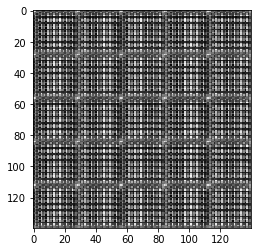

Epoch 1/2.... Batch 110... Discriminator Loss: 0.5950.... Generator Loss: 3.0420
Epoch 1/2.... Batch 120... Discriminator Loss: 0.8790.... Generator Loss: 3.2150
Epoch 1/2.... Batch 130... Discriminator Loss: 0.9398.... Generator Loss: 2.1483
Epoch 1/2.... Batch 140... Discriminator Loss: 0.8219.... Generator Loss: 1.8135
Epoch 1/2.... Batch 150... Discriminator Loss: 0.8829.... Generator Loss: 1.4823
Epoch 1/2.... Batch 160... Discriminator Loss: 0.6870.... Generator Loss: 2.5418
Epoch 1/2.... Batch 170... Discriminator Loss: 0.7816.... Generator Loss: 2.2061
Epoch 1/2.... Batch 180... Discriminator Loss: 1.2392.... Generator Loss: 0.8642
Epoch 1/2.... Batch 190... Discriminator Loss: 1.4748.... Generator Loss: 4.9761
Epoch 1/2.... Batch 200... Discriminator Loss: 0.8704.... Generator Loss: 2.0063


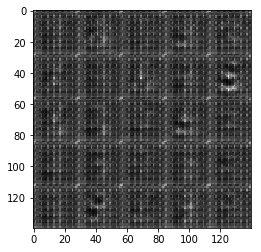

Epoch 1/2.... Batch 210... Discriminator Loss: 0.9541.... Generator Loss: 1.2261
Epoch 1/2.... Batch 220... Discriminator Loss: 0.8991.... Generator Loss: 2.6010
Epoch 1/2.... Batch 230... Discriminator Loss: 1.1263.... Generator Loss: 0.9213
Epoch 1/2.... Batch 240... Discriminator Loss: 1.1735.... Generator Loss: 3.5265
Epoch 1/2.... Batch 250... Discriminator Loss: 1.1520.... Generator Loss: 1.0270
Epoch 1/2.... Batch 260... Discriminator Loss: 1.0623.... Generator Loss: 1.0590
Epoch 1/2.... Batch 270... Discriminator Loss: 0.9850.... Generator Loss: 1.5126
Epoch 1/2.... Batch 280... Discriminator Loss: 1.1430.... Generator Loss: 0.9793
Epoch 1/2.... Batch 290... Discriminator Loss: 0.9240.... Generator Loss: 2.3837
Epoch 1/2.... Batch 300... Discriminator Loss: 1.0382.... Generator Loss: 2.2054


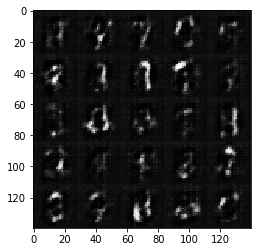

Epoch 1/2.... Batch 310... Discriminator Loss: 0.8518.... Generator Loss: 1.6838
Epoch 1/2.... Batch 320... Discriminator Loss: 0.8408.... Generator Loss: 1.7256
Epoch 1/2.... Batch 330... Discriminator Loss: 0.8375.... Generator Loss: 1.5992
Epoch 1/2.... Batch 340... Discriminator Loss: 0.8783.... Generator Loss: 1.8927
Epoch 1/2.... Batch 350... Discriminator Loss: 0.8419.... Generator Loss: 1.8323
Epoch 1/2.... Batch 360... Discriminator Loss: 0.7999.... Generator Loss: 1.9338
Epoch 1/2.... Batch 370... Discriminator Loss: 0.9243.... Generator Loss: 1.9562
Epoch 1/2.... Batch 380... Discriminator Loss: 1.1683.... Generator Loss: 2.9222
Epoch 1/2.... Batch 390... Discriminator Loss: 0.8293.... Generator Loss: 2.1192
Epoch 1/2.... Batch 400... Discriminator Loss: 1.0990.... Generator Loss: 2.8053


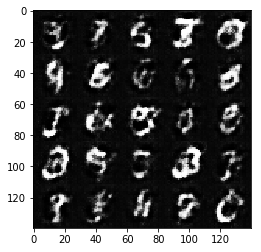

Epoch 1/2.... Batch 410... Discriminator Loss: 1.1561.... Generator Loss: 0.9972
Epoch 1/2.... Batch 420... Discriminator Loss: 1.0306.... Generator Loss: 1.1233
Epoch 1/2.... Batch 430... Discriminator Loss: 1.2510.... Generator Loss: 0.7685
Epoch 1/2.... Batch 440... Discriminator Loss: 0.8830.... Generator Loss: 1.8116
Epoch 1/2.... Batch 450... Discriminator Loss: 0.8553.... Generator Loss: 1.6728
Epoch 1/2.... Batch 460... Discriminator Loss: 1.6725.... Generator Loss: 0.4970
Epoch 1/2.... Batch 470... Discriminator Loss: 1.2276.... Generator Loss: 0.9130
Epoch 1/2.... Batch 480... Discriminator Loss: 0.8669.... Generator Loss: 1.4470
Epoch 1/2.... Batch 490... Discriminator Loss: 0.9335.... Generator Loss: 1.3071
Epoch 1/2.... Batch 500... Discriminator Loss: 0.9650.... Generator Loss: 1.2487


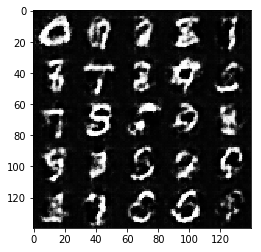

Epoch 1/2.... Batch 510... Discriminator Loss: 1.1879.... Generator Loss: 1.7555
Epoch 1/2.... Batch 520... Discriminator Loss: 1.1822.... Generator Loss: 0.9350
Epoch 1/2.... Batch 530... Discriminator Loss: 1.2483.... Generator Loss: 0.7701
Epoch 1/2.... Batch 540... Discriminator Loss: 1.0859.... Generator Loss: 1.0684
Epoch 1/2.... Batch 550... Discriminator Loss: 1.0072.... Generator Loss: 1.0909
Epoch 1/2.... Batch 560... Discriminator Loss: 1.0389.... Generator Loss: 1.0001
Epoch 1/2.... Batch 570... Discriminator Loss: 1.2233.... Generator Loss: 0.7728
Epoch 1/2.... Batch 580... Discriminator Loss: 0.9703.... Generator Loss: 1.2966
Epoch 1/2.... Batch 590... Discriminator Loss: 1.7846.... Generator Loss: 3.3669
Epoch 1/2.... Batch 600... Discriminator Loss: 0.9856.... Generator Loss: 2.0104


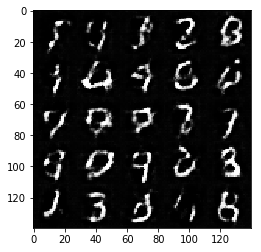

Epoch 1/2.... Batch 610... Discriminator Loss: 0.9587.... Generator Loss: 1.2690
Epoch 1/2.... Batch 620... Discriminator Loss: 2.3421.... Generator Loss: 0.2774
Epoch 1/2.... Batch 630... Discriminator Loss: 1.1774.... Generator Loss: 1.2875
Epoch 1/2.... Batch 640... Discriminator Loss: 1.1724.... Generator Loss: 0.8865
Epoch 1/2.... Batch 650... Discriminator Loss: 1.3083.... Generator Loss: 0.7748
Epoch 1/2.... Batch 660... Discriminator Loss: 1.0660.... Generator Loss: 2.4464
Epoch 1/2.... Batch 670... Discriminator Loss: 0.9836.... Generator Loss: 1.1222
Epoch 1/2.... Batch 680... Discriminator Loss: 1.2285.... Generator Loss: 2.4775
Epoch 1/2.... Batch 690... Discriminator Loss: 0.9484.... Generator Loss: 1.2361
Epoch 1/2.... Batch 700... Discriminator Loss: 1.2552.... Generator Loss: 2.6660


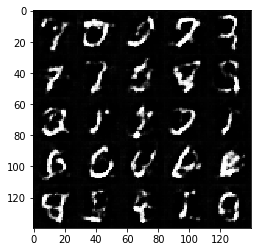

Epoch 1/2.... Batch 710... Discriminator Loss: 1.0247.... Generator Loss: 1.3296
Epoch 1/2.... Batch 720... Discriminator Loss: 0.9213.... Generator Loss: 1.3856
Epoch 1/2.... Batch 730... Discriminator Loss: 0.9518.... Generator Loss: 1.3297
Epoch 1/2.... Batch 740... Discriminator Loss: 1.1557.... Generator Loss: 0.9747
Epoch 1/2.... Batch 750... Discriminator Loss: 1.6071.... Generator Loss: 0.4975
Epoch 1/2.... Batch 760... Discriminator Loss: 1.1052.... Generator Loss: 0.9096
Epoch 1/2.... Batch 770... Discriminator Loss: 0.9482.... Generator Loss: 1.5930
Epoch 1/2.... Batch 780... Discriminator Loss: 1.5221.... Generator Loss: 3.8302
Epoch 1/2.... Batch 790... Discriminator Loss: 1.0824.... Generator Loss: 0.9866
Epoch 1/2.... Batch 800... Discriminator Loss: 0.9908.... Generator Loss: 1.3084


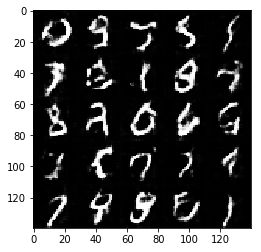

Epoch 1/2.... Batch 810... Discriminator Loss: 0.9972.... Generator Loss: 1.4294
Epoch 1/2.... Batch 820... Discriminator Loss: 1.5924.... Generator Loss: 0.6156
Epoch 1/2.... Batch 830... Discriminator Loss: 0.9482.... Generator Loss: 1.4931
Epoch 1/2.... Batch 840... Discriminator Loss: 1.2299.... Generator Loss: 0.8096
Epoch 1/2.... Batch 850... Discriminator Loss: 1.1991.... Generator Loss: 2.1702
Epoch 1/2.... Batch 860... Discriminator Loss: 0.9132.... Generator Loss: 1.7915
Epoch 1/2.... Batch 870... Discriminator Loss: 1.0854.... Generator Loss: 1.0059
Epoch 1/2.... Batch 880... Discriminator Loss: 1.1438.... Generator Loss: 0.8733
Epoch 1/2.... Batch 890... Discriminator Loss: 0.8985.... Generator Loss: 1.5209
Epoch 1/2.... Batch 900... Discriminator Loss: 1.0944.... Generator Loss: 0.9293


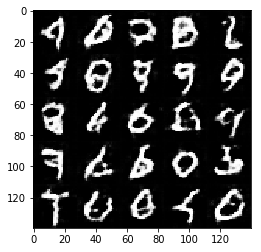

Epoch 1/2.... Batch 910... Discriminator Loss: 1.1314.... Generator Loss: 0.9198
Epoch 1/2.... Batch 920... Discriminator Loss: 0.9242.... Generator Loss: 1.8394
Epoch 1/2.... Batch 930... Discriminator Loss: 1.5496.... Generator Loss: 0.5122
Epoch 1/2.... Batch 940... Discriminator Loss: 1.2361.... Generator Loss: 0.7463
Epoch 1/2.... Batch 950... Discriminator Loss: 1.2981.... Generator Loss: 0.6969
Epoch 1/2.... Batch 960... Discriminator Loss: 0.9101.... Generator Loss: 1.6777
Epoch 1/2.... Batch 970... Discriminator Loss: 0.8324.... Generator Loss: 1.5638
Epoch 1/2.... Batch 980... Discriminator Loss: 0.7830.... Generator Loss: 1.7734
Epoch 1/2.... Batch 990... Discriminator Loss: 0.9904.... Generator Loss: 2.3031
Epoch 1/2.... Batch 1000... Discriminator Loss: 1.1185.... Generator Loss: 0.9412


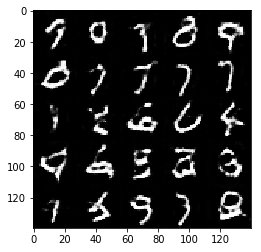

Epoch 1/2.... Batch 1010... Discriminator Loss: 0.9093.... Generator Loss: 1.5772
Epoch 1/2.... Batch 1020... Discriminator Loss: 1.4662.... Generator Loss: 0.6594
Epoch 1/2.... Batch 1030... Discriminator Loss: 1.0338.... Generator Loss: 1.0796
Epoch 1/2.... Batch 1040... Discriminator Loss: 1.1913.... Generator Loss: 0.9330
Epoch 1/2.... Batch 1050... Discriminator Loss: 0.9765.... Generator Loss: 1.6798
Epoch 1/2.... Batch 1060... Discriminator Loss: 1.1801.... Generator Loss: 0.8634
Epoch 1/2.... Batch 1070... Discriminator Loss: 1.2437.... Generator Loss: 2.2672
Epoch 1/2.... Batch 1080... Discriminator Loss: 0.8452.... Generator Loss: 1.4920
Epoch 1/2.... Batch 1090... Discriminator Loss: 0.9732.... Generator Loss: 1.6081
Epoch 1/2.... Batch 1100... Discriminator Loss: 0.8475.... Generator Loss: 2.2007


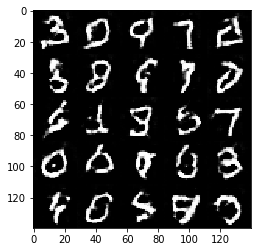

Epoch 1/2.... Batch 1110... Discriminator Loss: 1.2280.... Generator Loss: 0.8590
Epoch 1/2.... Batch 1120... Discriminator Loss: 0.9021.... Generator Loss: 2.0508
Epoch 1/2.... Batch 1130... Discriminator Loss: 1.2083.... Generator Loss: 0.8697
Epoch 1/2.... Batch 1140... Discriminator Loss: 0.9240.... Generator Loss: 1.3393
Epoch 1/2.... Batch 1150... Discriminator Loss: 1.0053.... Generator Loss: 1.1270
Epoch 1/2.... Batch 1160... Discriminator Loss: 1.0417.... Generator Loss: 1.3815
Epoch 1/2.... Batch 1170... Discriminator Loss: 0.7991.... Generator Loss: 1.8488
Epoch 1/2.... Batch 1180... Discriminator Loss: 1.0375.... Generator Loss: 1.4185
Epoch 1/2.... Batch 1190... Discriminator Loss: 0.9859.... Generator Loss: 2.3881
Epoch 1/2.... Batch 1200... Discriminator Loss: 0.9170.... Generator Loss: 1.3520


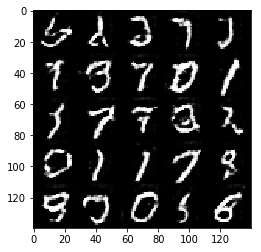

Epoch 1/2.... Batch 1210... Discriminator Loss: 0.9774.... Generator Loss: 1.2409
Epoch 1/2.... Batch 1220... Discriminator Loss: 1.3476.... Generator Loss: 3.6467
Epoch 1/2.... Batch 1230... Discriminator Loss: 1.0083.... Generator Loss: 1.1612
Epoch 1/2.... Batch 1240... Discriminator Loss: 0.9256.... Generator Loss: 1.4460
Epoch 1/2.... Batch 1250... Discriminator Loss: 0.9289.... Generator Loss: 1.2258
Epoch 1/2.... Batch 1260... Discriminator Loss: 1.0678.... Generator Loss: 1.0455
Epoch 1/2.... Batch 1270... Discriminator Loss: 0.7903.... Generator Loss: 1.5426
Epoch 1/2.... Batch 1280... Discriminator Loss: 0.8109.... Generator Loss: 2.0478
Epoch 1/2.... Batch 1290... Discriminator Loss: 0.8029.... Generator Loss: 1.7360
Epoch 1/2.... Batch 1300... Discriminator Loss: 2.4516.... Generator Loss: 0.2602


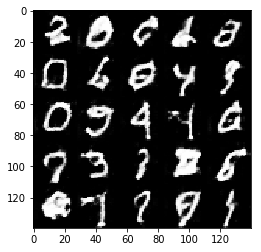

Epoch 1/2.... Batch 1310... Discriminator Loss: 1.5234.... Generator Loss: 0.5703
Epoch 1/2.... Batch 1320... Discriminator Loss: 0.9807.... Generator Loss: 1.3073
Epoch 1/2.... Batch 1330... Discriminator Loss: 1.1176.... Generator Loss: 0.8813
Epoch 1/2.... Batch 1340... Discriminator Loss: 0.8388.... Generator Loss: 1.5067
Epoch 1/2.... Batch 1350... Discriminator Loss: 1.1385.... Generator Loss: 2.8296
Epoch 1/2.... Batch 1360... Discriminator Loss: 1.0043.... Generator Loss: 1.1082
Epoch 1/2.... Batch 1370... Discriminator Loss: 0.8189.... Generator Loss: 1.9672
Epoch 1/2.... Batch 1380... Discriminator Loss: 0.9558.... Generator Loss: 1.2474
Epoch 1/2.... Batch 1390... Discriminator Loss: 0.8707.... Generator Loss: 1.8088
Epoch 1/2.... Batch 1400... Discriminator Loss: 1.1310.... Generator Loss: 0.9092


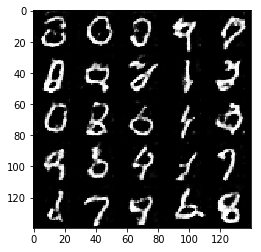

Epoch 1/2.... Batch 1410... Discriminator Loss: 0.8467.... Generator Loss: 1.4930
Epoch 1/2.... Batch 1420... Discriminator Loss: 0.8651.... Generator Loss: 1.4637
Epoch 1/2.... Batch 1430... Discriminator Loss: 0.8791.... Generator Loss: 1.4111
Epoch 1/2.... Batch 1440... Discriminator Loss: 0.9183.... Generator Loss: 1.2746
Epoch 1/2.... Batch 1450... Discriminator Loss: 0.8978.... Generator Loss: 2.1920
Epoch 1/2.... Batch 1460... Discriminator Loss: 0.8912.... Generator Loss: 1.7726
Epoch 1/2.... Batch 1470... Discriminator Loss: 0.9364.... Generator Loss: 1.5534
Epoch 1/2.... Batch 1480... Discriminator Loss: 0.8662.... Generator Loss: 1.4408
Epoch 1/2.... Batch 1490... Discriminator Loss: 1.0017.... Generator Loss: 2.5301
Epoch 1/2.... Batch 1500... Discriminator Loss: 1.2902.... Generator Loss: 0.7390


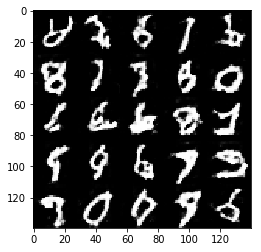

Epoch 1/2.... Batch 1510... Discriminator Loss: 0.7982.... Generator Loss: 1.7921
Epoch 1/2.... Batch 1520... Discriminator Loss: 1.3378.... Generator Loss: 0.7314
Epoch 1/2.... Batch 1530... Discriminator Loss: 0.7705.... Generator Loss: 1.8405
Epoch 1/2.... Batch 1540... Discriminator Loss: 0.9194.... Generator Loss: 2.0211
Epoch 1/2.... Batch 1550... Discriminator Loss: 0.9852.... Generator Loss: 1.0719
Epoch 1/2.... Batch 1560... Discriminator Loss: 0.8457.... Generator Loss: 1.4820
Epoch 1/2.... Batch 1570... Discriminator Loss: 1.4134.... Generator Loss: 0.6463
Epoch 1/2.... Batch 1580... Discriminator Loss: 1.0168.... Generator Loss: 1.1384
Epoch 1/2.... Batch 1590... Discriminator Loss: 0.7957.... Generator Loss: 1.5284
Epoch 1/2.... Batch 1600... Discriminator Loss: 1.0594.... Generator Loss: 1.0618


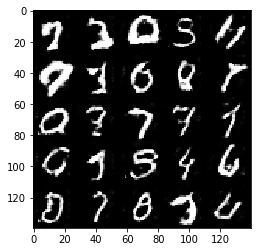

Epoch 1/2.... Batch 1610... Discriminator Loss: 0.9492.... Generator Loss: 1.5784
Epoch 1/2.... Batch 1620... Discriminator Loss: 0.8930.... Generator Loss: 1.3814
Epoch 1/2.... Batch 1630... Discriminator Loss: 0.9908.... Generator Loss: 1.0869
Epoch 1/2.... Batch 1640... Discriminator Loss: 0.8575.... Generator Loss: 2.1940
Epoch 1/2.... Batch 1650... Discriminator Loss: 0.9577.... Generator Loss: 2.2532
Epoch 1/2.... Batch 1660... Discriminator Loss: 1.0535.... Generator Loss: 1.0805
Epoch 1/2.... Batch 1670... Discriminator Loss: 2.3390.... Generator Loss: 0.2703
Epoch 1/2.... Batch 1680... Discriminator Loss: 0.9867.... Generator Loss: 1.6177
Epoch 1/2.... Batch 1690... Discriminator Loss: 0.9671.... Generator Loss: 1.2235
Epoch 1/2.... Batch 1700... Discriminator Loss: 0.7919.... Generator Loss: 1.6268


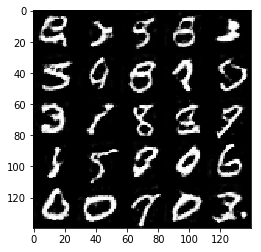

Epoch 1/2.... Batch 1710... Discriminator Loss: 1.2919.... Generator Loss: 0.7615
Epoch 1/2.... Batch 1720... Discriminator Loss: 0.8171.... Generator Loss: 1.9904
Epoch 1/2.... Batch 1730... Discriminator Loss: 0.7553.... Generator Loss: 2.0607
Epoch 1/2.... Batch 1740... Discriminator Loss: 0.9106.... Generator Loss: 1.3561
Epoch 1/2.... Batch 1750... Discriminator Loss: 0.8281.... Generator Loss: 1.6355
Epoch 1/2.... Batch 1760... Discriminator Loss: 0.8614.... Generator Loss: 2.0788
Epoch 1/2.... Batch 1770... Discriminator Loss: 1.0937.... Generator Loss: 0.9616
Epoch 1/2.... Batch 1780... Discriminator Loss: 0.9417.... Generator Loss: 1.2442
Epoch 1/2.... Batch 1790... Discriminator Loss: 0.9717.... Generator Loss: 2.2926
Epoch 1/2.... Batch 1800... Discriminator Loss: 1.3254.... Generator Loss: 0.7646


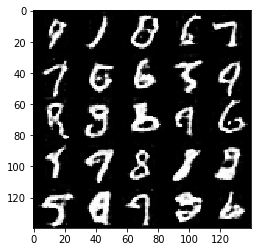

Epoch 1/2.... Batch 1810... Discriminator Loss: 1.0543.... Generator Loss: 1.0363
Epoch 1/2.... Batch 1820... Discriminator Loss: 0.9354.... Generator Loss: 1.2706
Epoch 1/2.... Batch 1830... Discriminator Loss: 0.8901.... Generator Loss: 1.4012
Epoch 1/2.... Batch 1840... Discriminator Loss: 0.9555.... Generator Loss: 1.2740
Epoch 1/2.... Batch 1850... Discriminator Loss: 0.9161.... Generator Loss: 1.3904
Epoch 1/2.... Batch 1860... Discriminator Loss: 1.0521.... Generator Loss: 1.6256
Epoch 1/2.... Batch 1870... Discriminator Loss: 0.8215.... Generator Loss: 1.6280
Epoch 2/2.... Batch 10... Discriminator Loss: 0.8817.... Generator Loss: 2.2070
Epoch 2/2.... Batch 20... Discriminator Loss: 0.8503.... Generator Loss: 1.7853
Epoch 2/2.... Batch 30... Discriminator Loss: 1.4744.... Generator Loss: 0.6255
Epoch 2/2.... Batch 40... Discriminator Loss: 0.8896.... Generator Loss: 1.3368
Epoch 2/2.... Batch 50... Discriminator Loss: 1.0872.... Generator Loss: 1.1096
Epoch 2/2.... Batch 60... 

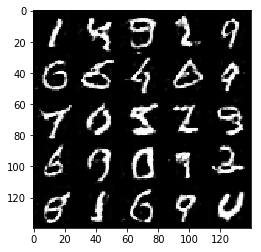

Epoch 2/2.... Batch 110... Discriminator Loss: 0.8943.... Generator Loss: 1.3690
Epoch 2/2.... Batch 120... Discriminator Loss: 0.8428.... Generator Loss: 1.8593
Epoch 2/2.... Batch 130... Discriminator Loss: 1.1494.... Generator Loss: 1.0225
Epoch 2/2.... Batch 140... Discriminator Loss: 1.0791.... Generator Loss: 1.0659
Epoch 2/2.... Batch 150... Discriminator Loss: 0.8608.... Generator Loss: 1.6924
Epoch 2/2.... Batch 160... Discriminator Loss: 0.9503.... Generator Loss: 1.4916
Epoch 2/2.... Batch 170... Discriminator Loss: 0.9306.... Generator Loss: 1.4963
Epoch 2/2.... Batch 180... Discriminator Loss: 0.8437.... Generator Loss: 1.5072
Epoch 2/2.... Batch 190... Discriminator Loss: 0.8464.... Generator Loss: 1.5203
Epoch 2/2.... Batch 200... Discriminator Loss: 0.8680.... Generator Loss: 1.4959


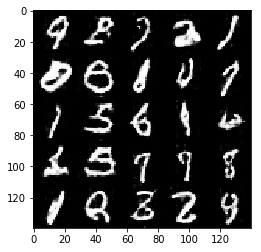

Epoch 2/2.... Batch 210... Discriminator Loss: 0.8516.... Generator Loss: 1.6374
Epoch 2/2.... Batch 220... Discriminator Loss: 0.9337.... Generator Loss: 1.5800
Epoch 2/2.... Batch 230... Discriminator Loss: 1.0966.... Generator Loss: 0.9815
Epoch 2/2.... Batch 240... Discriminator Loss: 1.0033.... Generator Loss: 1.1352
Epoch 2/2.... Batch 250... Discriminator Loss: 1.0693.... Generator Loss: 0.9781
Epoch 2/2.... Batch 260... Discriminator Loss: 0.8814.... Generator Loss: 2.2531
Epoch 2/2.... Batch 270... Discriminator Loss: 0.8334.... Generator Loss: 1.6132
Epoch 2/2.... Batch 280... Discriminator Loss: 0.8687.... Generator Loss: 1.4704
Epoch 2/2.... Batch 290... Discriminator Loss: 0.9229.... Generator Loss: 1.4106
Epoch 2/2.... Batch 300... Discriminator Loss: 0.9387.... Generator Loss: 1.2258


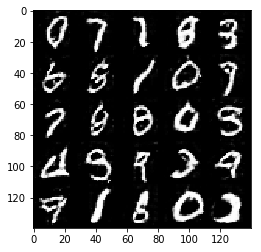

Epoch 2/2.... Batch 310... Discriminator Loss: 0.8481.... Generator Loss: 1.6976
Epoch 2/2.... Batch 320... Discriminator Loss: 1.3321.... Generator Loss: 0.7020
Epoch 2/2.... Batch 330... Discriminator Loss: 0.9347.... Generator Loss: 1.2132
Epoch 2/2.... Batch 340... Discriminator Loss: 0.9800.... Generator Loss: 1.0879
Epoch 2/2.... Batch 350... Discriminator Loss: 1.1539.... Generator Loss: 0.8819
Epoch 2/2.... Batch 360... Discriminator Loss: 1.2341.... Generator Loss: 2.9812
Epoch 2/2.... Batch 370... Discriminator Loss: 0.9337.... Generator Loss: 1.2722
Epoch 2/2.... Batch 380... Discriminator Loss: 0.8393.... Generator Loss: 1.8109
Epoch 2/2.... Batch 390... Discriminator Loss: 0.7256.... Generator Loss: 2.0258
Epoch 2/2.... Batch 400... Discriminator Loss: 0.9112.... Generator Loss: 1.3482


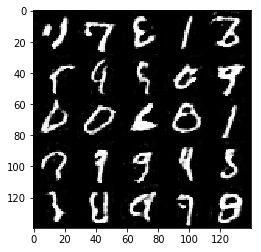

Epoch 2/2.... Batch 410... Discriminator Loss: 0.8157.... Generator Loss: 1.7479
Epoch 2/2.... Batch 420... Discriminator Loss: 0.7156.... Generator Loss: 2.3784
Epoch 2/2.... Batch 430... Discriminator Loss: 1.0819.... Generator Loss: 1.0357
Epoch 2/2.... Batch 440... Discriminator Loss: 0.9147.... Generator Loss: 1.2884
Epoch 2/2.... Batch 450... Discriminator Loss: 1.0147.... Generator Loss: 1.8304
Epoch 2/2.... Batch 460... Discriminator Loss: 0.9739.... Generator Loss: 1.2443
Epoch 2/2.... Batch 470... Discriminator Loss: 1.3885.... Generator Loss: 3.3786
Epoch 2/2.... Batch 480... Discriminator Loss: 0.9458.... Generator Loss: 1.8333
Epoch 2/2.... Batch 490... Discriminator Loss: 0.9982.... Generator Loss: 1.0602
Epoch 2/2.... Batch 500... Discriminator Loss: 0.7276.... Generator Loss: 2.4825


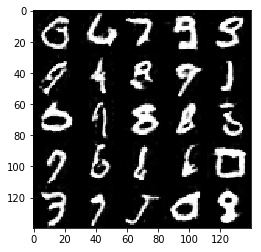

Epoch 2/2.... Batch 510... Discriminator Loss: 1.0519.... Generator Loss: 1.1872
Epoch 2/2.... Batch 520... Discriminator Loss: 1.1215.... Generator Loss: 0.9898
Epoch 2/2.... Batch 530... Discriminator Loss: 0.8880.... Generator Loss: 1.8462
Epoch 2/2.... Batch 540... Discriminator Loss: 1.0300.... Generator Loss: 1.1487
Epoch 2/2.... Batch 550... Discriminator Loss: 0.9712.... Generator Loss: 1.2526
Epoch 2/2.... Batch 560... Discriminator Loss: 0.8881.... Generator Loss: 1.4749
Epoch 2/2.... Batch 570... Discriminator Loss: 0.9617.... Generator Loss: 1.3803
Epoch 2/2.... Batch 580... Discriminator Loss: 0.9608.... Generator Loss: 1.2987
Epoch 2/2.... Batch 590... Discriminator Loss: 0.8765.... Generator Loss: 1.4579
Epoch 2/2.... Batch 600... Discriminator Loss: 0.8999.... Generator Loss: 1.9567


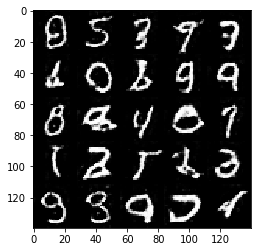

Epoch 2/2.... Batch 610... Discriminator Loss: 0.9291.... Generator Loss: 1.9129
Epoch 2/2.... Batch 620... Discriminator Loss: 0.8728.... Generator Loss: 2.1262
Epoch 2/2.... Batch 630... Discriminator Loss: 0.8473.... Generator Loss: 1.6977
Epoch 2/2.... Batch 640... Discriminator Loss: 1.5911.... Generator Loss: 0.5841
Epoch 2/2.... Batch 650... Discriminator Loss: 1.1531.... Generator Loss: 2.9359
Epoch 2/2.... Batch 660... Discriminator Loss: 0.8365.... Generator Loss: 1.9469
Epoch 2/2.... Batch 670... Discriminator Loss: 0.9065.... Generator Loss: 1.3580
Epoch 2/2.... Batch 680... Discriminator Loss: 1.0879.... Generator Loss: 1.9829
Epoch 2/2.... Batch 690... Discriminator Loss: 1.1217.... Generator Loss: 1.0583
Epoch 2/2.... Batch 700... Discriminator Loss: 0.8438.... Generator Loss: 2.2577


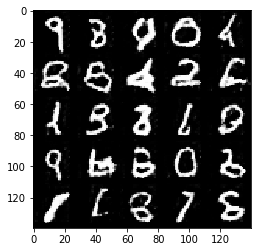

Epoch 2/2.... Batch 710... Discriminator Loss: 0.9283.... Generator Loss: 1.3720
Epoch 2/2.... Batch 720... Discriminator Loss: 0.8240.... Generator Loss: 1.6198
Epoch 2/2.... Batch 730... Discriminator Loss: 0.8215.... Generator Loss: 1.6783
Epoch 2/2.... Batch 740... Discriminator Loss: 1.0197.... Generator Loss: 1.0530
Epoch 2/2.... Batch 750... Discriminator Loss: 0.8724.... Generator Loss: 2.0052
Epoch 2/2.... Batch 760... Discriminator Loss: 0.9585.... Generator Loss: 1.2660
Epoch 2/2.... Batch 770... Discriminator Loss: 0.8897.... Generator Loss: 1.9215
Epoch 2/2.... Batch 780... Discriminator Loss: 0.8925.... Generator Loss: 2.1862
Epoch 2/2.... Batch 790... Discriminator Loss: 0.9573.... Generator Loss: 1.2964
Epoch 2/2.... Batch 800... Discriminator Loss: 0.9484.... Generator Loss: 1.2941


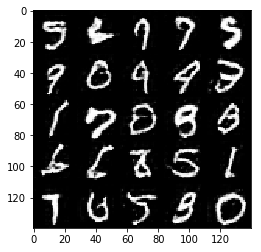

Epoch 2/2.... Batch 810... Discriminator Loss: 0.7880.... Generator Loss: 1.7489
Epoch 2/2.... Batch 820... Discriminator Loss: 0.7208.... Generator Loss: 2.2661
Epoch 2/2.... Batch 830... Discriminator Loss: 0.8239.... Generator Loss: 1.6574
Epoch 2/2.... Batch 840... Discriminator Loss: 1.5648.... Generator Loss: 0.5755
Epoch 2/2.... Batch 850... Discriminator Loss: 0.8244.... Generator Loss: 1.6454
Epoch 2/2.... Batch 860... Discriminator Loss: 0.8799.... Generator Loss: 1.5008
Epoch 2/2.... Batch 870... Discriminator Loss: 1.0839.... Generator Loss: 2.2675
Epoch 2/2.... Batch 880... Discriminator Loss: 1.2279.... Generator Loss: 0.8353
Epoch 2/2.... Batch 890... Discriminator Loss: 1.2923.... Generator Loss: 0.8870
Epoch 2/2.... Batch 900... Discriminator Loss: 0.8495.... Generator Loss: 1.8314


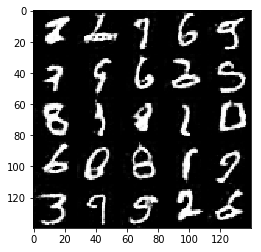

Epoch 2/2.... Batch 910... Discriminator Loss: 1.0062.... Generator Loss: 1.1483
Epoch 2/2.... Batch 920... Discriminator Loss: 0.8927.... Generator Loss: 1.4965
Epoch 2/2.... Batch 930... Discriminator Loss: 0.9304.... Generator Loss: 1.9047
Epoch 2/2.... Batch 940... Discriminator Loss: 1.3093.... Generator Loss: 0.8086
Epoch 2/2.... Batch 950... Discriminator Loss: 1.2848.... Generator Loss: 0.8179
Epoch 2/2.... Batch 960... Discriminator Loss: 0.9386.... Generator Loss: 1.8547
Epoch 2/2.... Batch 970... Discriminator Loss: 0.7671.... Generator Loss: 1.7160
Epoch 2/2.... Batch 980... Discriminator Loss: 1.0219.... Generator Loss: 2.7264
Epoch 2/2.... Batch 990... Discriminator Loss: 1.4072.... Generator Loss: 0.7822
Epoch 2/2.... Batch 1000... Discriminator Loss: 1.0493.... Generator Loss: 1.1553


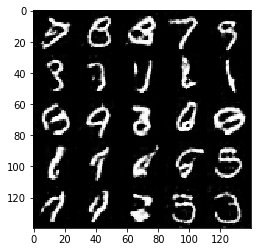

Epoch 2/2.... Batch 1010... Discriminator Loss: 0.8995.... Generator Loss: 2.2650
Epoch 2/2.... Batch 1020... Discriminator Loss: 0.7892.... Generator Loss: 2.2989
Epoch 2/2.... Batch 1030... Discriminator Loss: 0.8393.... Generator Loss: 1.6207
Epoch 2/2.... Batch 1040... Discriminator Loss: 0.9903.... Generator Loss: 1.2581
Epoch 2/2.... Batch 1050... Discriminator Loss: 0.8846.... Generator Loss: 1.4341
Epoch 2/2.... Batch 1060... Discriminator Loss: 1.4213.... Generator Loss: 0.7248
Epoch 2/2.... Batch 1070... Discriminator Loss: 0.8520.... Generator Loss: 1.8989
Epoch 2/2.... Batch 1080... Discriminator Loss: 0.8864.... Generator Loss: 1.3987
Epoch 2/2.... Batch 1090... Discriminator Loss: 1.0408.... Generator Loss: 1.0349
Epoch 2/2.... Batch 1100... Discriminator Loss: 0.8513.... Generator Loss: 1.7328


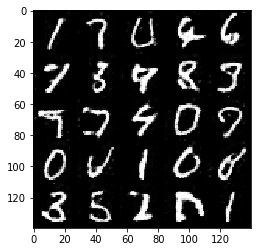

Epoch 2/2.... Batch 1110... Discriminator Loss: 1.0865.... Generator Loss: 1.0563
Epoch 2/2.... Batch 1120... Discriminator Loss: 1.6168.... Generator Loss: 0.6391
Epoch 2/2.... Batch 1130... Discriminator Loss: 0.9631.... Generator Loss: 2.4881
Epoch 2/2.... Batch 1140... Discriminator Loss: 0.7828.... Generator Loss: 1.8340
Epoch 2/2.... Batch 1150... Discriminator Loss: 0.8901.... Generator Loss: 1.4048
Epoch 2/2.... Batch 1160... Discriminator Loss: 1.1283.... Generator Loss: 1.1085
Epoch 2/2.... Batch 1170... Discriminator Loss: 0.7420.... Generator Loss: 1.9737
Epoch 2/2.... Batch 1180... Discriminator Loss: 0.9817.... Generator Loss: 2.3365
Epoch 2/2.... Batch 1190... Discriminator Loss: 0.8543.... Generator Loss: 1.5544
Epoch 2/2.... Batch 1200... Discriminator Loss: 0.9193.... Generator Loss: 1.2783


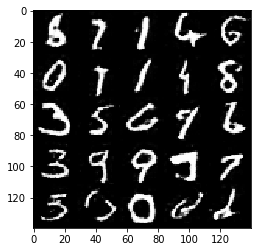

Epoch 2/2.... Batch 1210... Discriminator Loss: 0.8699.... Generator Loss: 2.0358
Epoch 2/2.... Batch 1220... Discriminator Loss: 1.3384.... Generator Loss: 0.6912
Epoch 2/2.... Batch 1230... Discriminator Loss: 0.9935.... Generator Loss: 1.2493
Epoch 2/2.... Batch 1240... Discriminator Loss: 0.7471.... Generator Loss: 2.6052
Epoch 2/2.... Batch 1250... Discriminator Loss: 1.2000.... Generator Loss: 2.8595
Epoch 2/2.... Batch 1260... Discriminator Loss: 2.0515.... Generator Loss: 0.4322
Epoch 2/2.... Batch 1270... Discriminator Loss: 0.8857.... Generator Loss: 1.5177
Epoch 2/2.... Batch 1280... Discriminator Loss: 0.8595.... Generator Loss: 1.5417
Epoch 2/2.... Batch 1290... Discriminator Loss: 0.9133.... Generator Loss: 2.0858
Epoch 2/2.... Batch 1300... Discriminator Loss: 0.8409.... Generator Loss: 1.6596


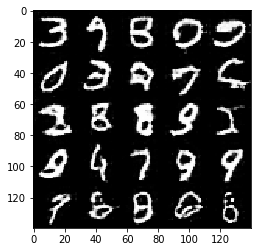

Epoch 2/2.... Batch 1310... Discriminator Loss: 1.0789.... Generator Loss: 1.1201
Epoch 2/2.... Batch 1320... Discriminator Loss: 0.8087.... Generator Loss: 1.7704
Epoch 2/2.... Batch 1330... Discriminator Loss: 0.7784.... Generator Loss: 1.8154
Epoch 2/2.... Batch 1340... Discriminator Loss: 0.7988.... Generator Loss: 1.7103
Epoch 2/2.... Batch 1350... Discriminator Loss: 0.8891.... Generator Loss: 1.5129
Epoch 2/2.... Batch 1360... Discriminator Loss: 1.0407.... Generator Loss: 1.0874
Epoch 2/2.... Batch 1370... Discriminator Loss: 0.8035.... Generator Loss: 1.8763
Epoch 2/2.... Batch 1380... Discriminator Loss: 0.8060.... Generator Loss: 1.8308
Epoch 2/2.... Batch 1390... Discriminator Loss: 1.0402.... Generator Loss: 1.2531
Epoch 2/2.... Batch 1400... Discriminator Loss: 1.1480.... Generator Loss: 1.0461


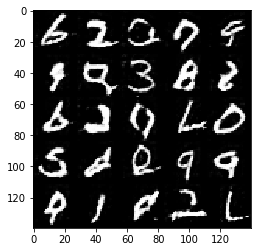

Epoch 2/2.... Batch 1410... Discriminator Loss: 0.8860.... Generator Loss: 1.4244
Epoch 2/2.... Batch 1420... Discriminator Loss: 0.9524.... Generator Loss: 1.2202
Epoch 2/2.... Batch 1430... Discriminator Loss: 0.8371.... Generator Loss: 1.8709
Epoch 2/2.... Batch 1440... Discriminator Loss: 0.8075.... Generator Loss: 2.0212
Epoch 2/2.... Batch 1450... Discriminator Loss: 1.5086.... Generator Loss: 4.2145
Epoch 2/2.... Batch 1460... Discriminator Loss: 1.1004.... Generator Loss: 0.9861
Epoch 2/2.... Batch 1470... Discriminator Loss: 0.9769.... Generator Loss: 1.2480
Epoch 2/2.... Batch 1480... Discriminator Loss: 0.8916.... Generator Loss: 1.4204
Epoch 2/2.... Batch 1490... Discriminator Loss: 0.9909.... Generator Loss: 1.1844
Epoch 2/2.... Batch 1500... Discriminator Loss: 0.9258.... Generator Loss: 1.3383


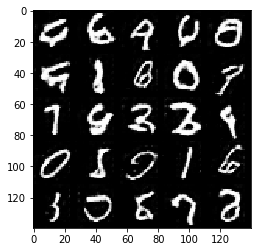

Epoch 2/2.... Batch 1510... Discriminator Loss: 1.2511.... Generator Loss: 0.7511
Epoch 2/2.... Batch 1520... Discriminator Loss: 0.8366.... Generator Loss: 1.6218
Epoch 2/2.... Batch 1530... Discriminator Loss: 1.0227.... Generator Loss: 1.1398
Epoch 2/2.... Batch 1540... Discriminator Loss: 1.2531.... Generator Loss: 0.8245
Epoch 2/2.... Batch 1550... Discriminator Loss: 0.8742.... Generator Loss: 1.4581
Epoch 2/2.... Batch 1560... Discriminator Loss: 0.8950.... Generator Loss: 1.3237
Epoch 2/2.... Batch 1570... Discriminator Loss: 1.8373.... Generator Loss: 0.4594
Epoch 2/2.... Batch 1580... Discriminator Loss: 0.8706.... Generator Loss: 1.5732
Epoch 2/2.... Batch 1590... Discriminator Loss: 1.0035.... Generator Loss: 1.1098
Epoch 2/2.... Batch 1600... Discriminator Loss: 1.0784.... Generator Loss: 1.0606


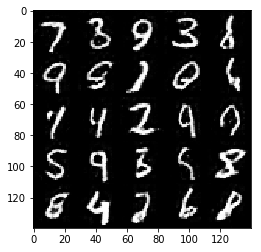

Epoch 2/2.... Batch 1610... Discriminator Loss: 0.8955.... Generator Loss: 1.3727
Epoch 2/2.... Batch 1620... Discriminator Loss: 1.0483.... Generator Loss: 1.0955
Epoch 2/2.... Batch 1630... Discriminator Loss: 1.1351.... Generator Loss: 1.0003
Epoch 2/2.... Batch 1640... Discriminator Loss: 0.8372.... Generator Loss: 2.0094
Epoch 2/2.... Batch 1650... Discriminator Loss: 0.7917.... Generator Loss: 1.8631
Epoch 2/2.... Batch 1660... Discriminator Loss: 0.6824.... Generator Loss: 2.5529
Epoch 2/2.... Batch 1670... Discriminator Loss: 0.9026.... Generator Loss: 1.3522
Epoch 2/2.... Batch 1680... Discriminator Loss: 0.9273.... Generator Loss: 1.2898
Epoch 2/2.... Batch 1690... Discriminator Loss: 0.9588.... Generator Loss: 1.3654
Epoch 2/2.... Batch 1700... Discriminator Loss: 0.9589.... Generator Loss: 1.2189


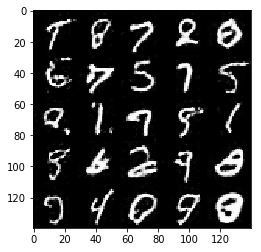

Epoch 2/2.... Batch 1710... Discriminator Loss: 0.8117.... Generator Loss: 1.6821
Epoch 2/2.... Batch 1720... Discriminator Loss: 1.0830.... Generator Loss: 1.0076
Epoch 2/2.... Batch 1730... Discriminator Loss: 0.7355.... Generator Loss: 2.0743
Epoch 2/2.... Batch 1740... Discriminator Loss: 0.7931.... Generator Loss: 1.7734
Epoch 2/2.... Batch 1750... Discriminator Loss: 0.9258.... Generator Loss: 1.3054
Epoch 2/2.... Batch 1760... Discriminator Loss: 0.8357.... Generator Loss: 1.5329
Epoch 2/2.... Batch 1770... Discriminator Loss: 0.9764.... Generator Loss: 1.1997
Epoch 2/2.... Batch 1780... Discriminator Loss: 0.9494.... Generator Loss: 1.3261
Epoch 2/2.... Batch 1790... Discriminator Loss: 0.8122.... Generator Loss: 1.6460
Epoch 2/2.... Batch 1800... Discriminator Loss: 1.4176.... Generator Loss: 0.6314


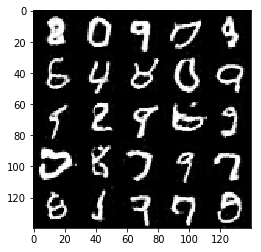

Epoch 2/2.... Batch 1810... Discriminator Loss: 0.9406.... Generator Loss: 1.2475
Epoch 2/2.... Batch 1820... Discriminator Loss: 0.8502.... Generator Loss: 1.5766
Epoch 2/2.... Batch 1830... Discriminator Loss: 0.9042.... Generator Loss: 1.8334
Epoch 2/2.... Batch 1840... Discriminator Loss: 0.8037.... Generator Loss: 1.9499
Epoch 2/2.... Batch 1850... Discriminator Loss: 0.8533.... Generator Loss: 1.7148
Epoch 2/2.... Batch 1860... Discriminator Loss: 1.0482.... Generator Loss: 1.4228
Epoch 2/2.... Batch 1870... Discriminator Loss: 0.8566.... Generator Loss: 1.5915


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1.... Batch 10... Discriminator Loss: 2.8254.... Generator Loss: 0.1494
Epoch 1/1.... Batch 20... Discriminator Loss: 1.7079.... Generator Loss: 0.4412
Epoch 1/1.... Batch 30... Discriminator Loss: 0.5956.... Generator Loss: 4.8562
Epoch 1/1.... Batch 40... Discriminator Loss: 0.7700.... Generator Loss: 8.7257
Epoch 1/1.... Batch 50... Discriminator Loss: 1.2090.... Generator Loss: 0.9022
Epoch 1/1.... Batch 60... Discriminator Loss: 1.8049.... Generator Loss: 0.4508
Epoch 1/1.... Batch 70... Discriminator Loss: 0.8009.... Generator Loss: 6.8699
Epoch 1/1.... Batch 80... Discriminator Loss: 0.8349.... Generator Loss: 1.6695
Epoch 1/1.... Batch 90... Discriminator Loss: 1.2153.... Generator Loss: 0.7843
Epoch 1/1.... Batch 100... Discriminator Loss: 0.7829.... Generator Loss: 3.0664


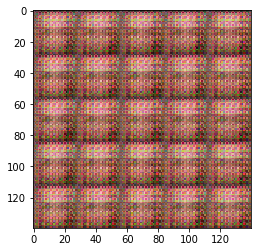

Epoch 1/1.... Batch 110... Discriminator Loss: 0.7245.... Generator Loss: 2.7482
Epoch 1/1.... Batch 120... Discriminator Loss: 0.7145.... Generator Loss: 2.4037
Epoch 1/1.... Batch 130... Discriminator Loss: 0.6353.... Generator Loss: 3.1091
Epoch 1/1.... Batch 140... Discriminator Loss: 0.6156.... Generator Loss: 3.2565
Epoch 1/1.... Batch 150... Discriminator Loss: 0.6880.... Generator Loss: 2.6875
Epoch 1/1.... Batch 160... Discriminator Loss: 0.6402.... Generator Loss: 2.8829
Epoch 1/1.... Batch 170... Discriminator Loss: 0.6792.... Generator Loss: 4.8167
Epoch 1/1.... Batch 180... Discriminator Loss: 0.6697.... Generator Loss: 2.5552
Epoch 1/1.... Batch 190... Discriminator Loss: 0.6812.... Generator Loss: 3.2518
Epoch 1/1.... Batch 200... Discriminator Loss: 0.8137.... Generator Loss: 2.1380


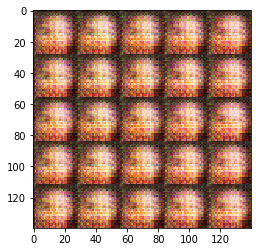

Epoch 1/1.... Batch 210... Discriminator Loss: 0.6687.... Generator Loss: 8.2479
Epoch 1/1.... Batch 220... Discriminator Loss: 0.6489.... Generator Loss: 3.3071
Epoch 1/1.... Batch 230... Discriminator Loss: 0.6275.... Generator Loss: 4.8546
Epoch 1/1.... Batch 240... Discriminator Loss: 0.6257.... Generator Loss: 3.3169
Epoch 1/1.... Batch 250... Discriminator Loss: 0.6268.... Generator Loss: 3.1820
Epoch 1/1.... Batch 260... Discriminator Loss: 0.6636.... Generator Loss: 3.0477
Epoch 1/1.... Batch 270... Discriminator Loss: 0.5794.... Generator Loss: 3.5337
Epoch 1/1.... Batch 280... Discriminator Loss: 0.6102.... Generator Loss: 3.0077
Epoch 1/1.... Batch 290... Discriminator Loss: 0.6784.... Generator Loss: 2.7756
Epoch 1/1.... Batch 300... Discriminator Loss: 0.5550.... Generator Loss: 3.8857


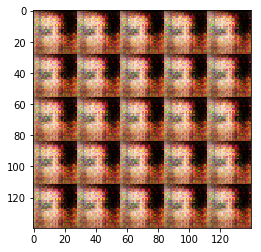

Epoch 1/1.... Batch 310... Discriminator Loss: 0.5622.... Generator Loss: 4.2682
Epoch 1/1.... Batch 320... Discriminator Loss: 0.5796.... Generator Loss: 3.5495
Epoch 1/1.... Batch 330... Discriminator Loss: 0.6898.... Generator Loss: 1.9870
Epoch 1/1.... Batch 340... Discriminator Loss: 0.6081.... Generator Loss: 2.9688
Epoch 1/1.... Batch 350... Discriminator Loss: 0.5547.... Generator Loss: 4.3011
Epoch 1/1.... Batch 360... Discriminator Loss: 0.6658.... Generator Loss: 2.4154
Epoch 1/1.... Batch 370... Discriminator Loss: 0.6165.... Generator Loss: 3.3307
Epoch 1/1.... Batch 380... Discriminator Loss: 0.5839.... Generator Loss: 3.2670
Epoch 1/1.... Batch 390... Discriminator Loss: 0.6027.... Generator Loss: 4.3168
Epoch 1/1.... Batch 400... Discriminator Loss: 0.5811.... Generator Loss: 5.3522


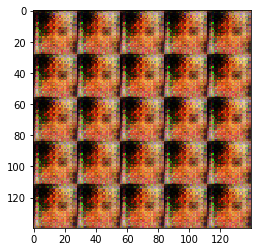

Epoch 1/1.... Batch 410... Discriminator Loss: 0.5644.... Generator Loss: 3.5234
Epoch 1/1.... Batch 420... Discriminator Loss: 0.5966.... Generator Loss: 4.5424
Epoch 1/1.... Batch 430... Discriminator Loss: 0.7496.... Generator Loss: 1.9007
Epoch 1/1.... Batch 440... Discriminator Loss: 0.5664.... Generator Loss: 4.5527
Epoch 1/1.... Batch 450... Discriminator Loss: 0.6098.... Generator Loss: 3.7354
Epoch 1/1.... Batch 460... Discriminator Loss: 0.6070.... Generator Loss: 2.7907
Epoch 1/1.... Batch 470... Discriminator Loss: 0.5606.... Generator Loss: 4.7697
Epoch 1/1.... Batch 480... Discriminator Loss: 0.5645.... Generator Loss: 3.9302
Epoch 1/1.... Batch 490... Discriminator Loss: 0.5818.... Generator Loss: 3.4139
Epoch 1/1.... Batch 500... Discriminator Loss: 0.5503.... Generator Loss: 4.3374


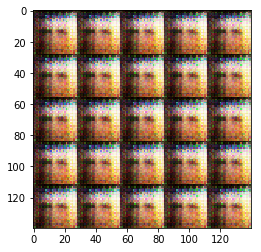

Epoch 1/1.... Batch 510... Discriminator Loss: 0.5730.... Generator Loss: 3.3961
Epoch 1/1.... Batch 520... Discriminator Loss: 0.5506.... Generator Loss: 3.9251
Epoch 1/1.... Batch 530... Discriminator Loss: 0.5663.... Generator Loss: 4.1439
Epoch 1/1.... Batch 540... Discriminator Loss: 0.6111.... Generator Loss: 3.1381
Epoch 1/1.... Batch 550... Discriminator Loss: 0.5948.... Generator Loss: 3.9408
Epoch 1/1.... Batch 560... Discriminator Loss: 0.5743.... Generator Loss: 3.4140
Epoch 1/1.... Batch 570... Discriminator Loss: 0.5619.... Generator Loss: 3.8065
Epoch 1/1.... Batch 580... Discriminator Loss: 0.5554.... Generator Loss: 3.7538
Epoch 1/1.... Batch 590... Discriminator Loss: 0.5421.... Generator Loss: 3.7028
Epoch 1/1.... Batch 600... Discriminator Loss: 0.5553.... Generator Loss: 4.7756


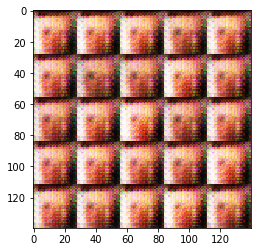

Epoch 1/1.... Batch 610... Discriminator Loss: 0.6322.... Generator Loss: 3.7491
Epoch 1/1.... Batch 620... Discriminator Loss: 0.6054.... Generator Loss: 2.8992
Epoch 1/1.... Batch 630... Discriminator Loss: 0.8125.... Generator Loss: 4.2779
Epoch 1/1.... Batch 640... Discriminator Loss: 0.8461.... Generator Loss: 3.6290
Epoch 1/1.... Batch 650... Discriminator Loss: 2.0831.... Generator Loss: 0.4962
Epoch 1/1.... Batch 660... Discriminator Loss: 0.7011.... Generator Loss: 2.5417
Epoch 1/1.... Batch 670... Discriminator Loss: 1.0390.... Generator Loss: 5.2594
Epoch 1/1.... Batch 680... Discriminator Loss: 0.7745.... Generator Loss: 2.1169
Epoch 1/1.... Batch 690... Discriminator Loss: 0.8433.... Generator Loss: 1.9902
Epoch 1/1.... Batch 700... Discriminator Loss: 1.2164.... Generator Loss: 0.8977


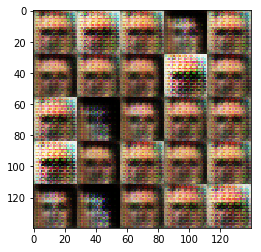

Epoch 1/1.... Batch 710... Discriminator Loss: 0.7961.... Generator Loss: 1.8586
Epoch 1/1.... Batch 720... Discriminator Loss: 0.9501.... Generator Loss: 2.2868
Epoch 1/1.... Batch 730... Discriminator Loss: 0.9244.... Generator Loss: 2.5844
Epoch 1/1.... Batch 740... Discriminator Loss: 0.9715.... Generator Loss: 1.8916
Epoch 1/1.... Batch 750... Discriminator Loss: 0.7387.... Generator Loss: 1.9074
Epoch 1/1.... Batch 760... Discriminator Loss: 1.1213.... Generator Loss: 1.0340
Epoch 1/1.... Batch 770... Discriminator Loss: 0.7726.... Generator Loss: 1.8749
Epoch 1/1.... Batch 780... Discriminator Loss: 1.2607.... Generator Loss: 0.8397
Epoch 1/1.... Batch 790... Discriminator Loss: 0.6644.... Generator Loss: 3.0232
Epoch 1/1.... Batch 800... Discriminator Loss: 0.8797.... Generator Loss: 1.6924


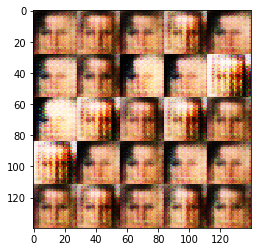

Epoch 1/1.... Batch 810... Discriminator Loss: 1.0106.... Generator Loss: 3.9141
Epoch 1/1.... Batch 820... Discriminator Loss: 1.0639.... Generator Loss: 1.0445
Epoch 1/1.... Batch 830... Discriminator Loss: 0.8012.... Generator Loss: 1.9266
Epoch 1/1.... Batch 840... Discriminator Loss: 0.6696.... Generator Loss: 2.3340
Epoch 1/1.... Batch 850... Discriminator Loss: 0.8806.... Generator Loss: 3.5618
Epoch 1/1.... Batch 860... Discriminator Loss: 0.8125.... Generator Loss: 1.8339
Epoch 1/1.... Batch 870... Discriminator Loss: 0.8363.... Generator Loss: 1.6105
Epoch 1/1.... Batch 880... Discriminator Loss: 0.8421.... Generator Loss: 1.7443
Epoch 1/1.... Batch 890... Discriminator Loss: 0.8189.... Generator Loss: 2.5051
Epoch 1/1.... Batch 900... Discriminator Loss: 0.7605.... Generator Loss: 2.0336


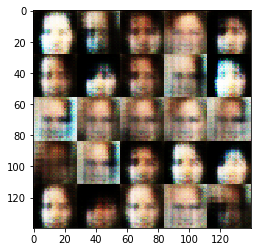

Epoch 1/1.... Batch 910... Discriminator Loss: 0.7658.... Generator Loss: 1.7899
Epoch 1/1.... Batch 920... Discriminator Loss: 0.9030.... Generator Loss: 2.9613
Epoch 1/1.... Batch 930... Discriminator Loss: 1.2493.... Generator Loss: 0.8223
Epoch 1/1.... Batch 940... Discriminator Loss: 0.9794.... Generator Loss: 1.2600
Epoch 1/1.... Batch 950... Discriminator Loss: 0.8731.... Generator Loss: 1.4648
Epoch 1/1.... Batch 960... Discriminator Loss: 1.4554.... Generator Loss: 0.6249
Epoch 1/1.... Batch 970... Discriminator Loss: 0.7503.... Generator Loss: 1.8466
Epoch 1/1.... Batch 980... Discriminator Loss: 0.9921.... Generator Loss: 1.1559
Epoch 1/1.... Batch 990... Discriminator Loss: 0.9560.... Generator Loss: 1.4757
Epoch 1/1.... Batch 1000... Discriminator Loss: 0.8589.... Generator Loss: 1.4941


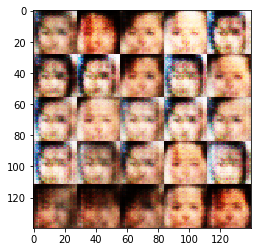

Epoch 1/1.... Batch 1010... Discriminator Loss: 0.7679.... Generator Loss: 2.3787
Epoch 1/1.... Batch 1020... Discriminator Loss: 0.8091.... Generator Loss: 2.1870
Epoch 1/1.... Batch 1030... Discriminator Loss: 0.7933.... Generator Loss: 1.7018
Epoch 1/1.... Batch 1040... Discriminator Loss: 0.8254.... Generator Loss: 2.7647
Epoch 1/1.... Batch 1050... Discriminator Loss: 0.8661.... Generator Loss: 1.6747
Epoch 1/1.... Batch 1060... Discriminator Loss: 0.8709.... Generator Loss: 2.4611
Epoch 1/1.... Batch 1070... Discriminator Loss: 1.0991.... Generator Loss: 1.0335
Epoch 1/1.... Batch 1080... Discriminator Loss: 0.9672.... Generator Loss: 2.6020
Epoch 1/1.... Batch 1090... Discriminator Loss: 0.9678.... Generator Loss: 1.6531
Epoch 1/1.... Batch 1100... Discriminator Loss: 0.9719.... Generator Loss: 1.2703


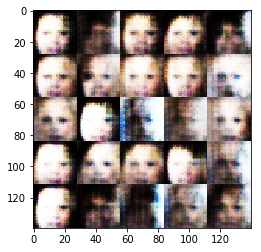

Epoch 1/1.... Batch 1110... Discriminator Loss: 0.8803.... Generator Loss: 1.8685
Epoch 1/1.... Batch 1120... Discriminator Loss: 0.9359.... Generator Loss: 3.6775
Epoch 1/1.... Batch 1130... Discriminator Loss: 0.8992.... Generator Loss: 1.6911
Epoch 1/1.... Batch 1140... Discriminator Loss: 0.9497.... Generator Loss: 2.7188
Epoch 1/1.... Batch 1150... Discriminator Loss: 0.8387.... Generator Loss: 1.7340
Epoch 1/1.... Batch 1160... Discriminator Loss: 0.9261.... Generator Loss: 1.6715
Epoch 1/1.... Batch 1170... Discriminator Loss: 1.2153.... Generator Loss: 0.8246
Epoch 1/1.... Batch 1180... Discriminator Loss: 1.4770.... Generator Loss: 5.6413
Epoch 1/1.... Batch 1190... Discriminator Loss: 0.8807.... Generator Loss: 2.4588
Epoch 1/1.... Batch 1200... Discriminator Loss: 0.9072.... Generator Loss: 2.5429


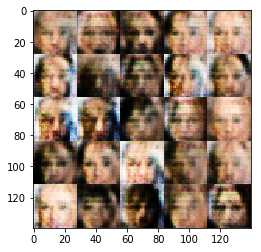

Epoch 1/1.... Batch 1210... Discriminator Loss: 1.0227.... Generator Loss: 1.3234
Epoch 1/1.... Batch 1220... Discriminator Loss: 0.9576.... Generator Loss: 1.4083
Epoch 1/1.... Batch 1230... Discriminator Loss: 1.5611.... Generator Loss: 0.5344
Epoch 1/1.... Batch 1240... Discriminator Loss: 0.9426.... Generator Loss: 1.4530
Epoch 1/1.... Batch 1250... Discriminator Loss: 0.9176.... Generator Loss: 1.9418
Epoch 1/1.... Batch 1260... Discriminator Loss: 1.1781.... Generator Loss: 3.7878
Epoch 1/1.... Batch 1270... Discriminator Loss: 1.0160.... Generator Loss: 1.3193
Epoch 1/1.... Batch 1280... Discriminator Loss: 1.0228.... Generator Loss: 1.9294
Epoch 1/1.... Batch 1290... Discriminator Loss: 0.9795.... Generator Loss: 1.2128
Epoch 1/1.... Batch 1300... Discriminator Loss: 1.0207.... Generator Loss: 2.3937


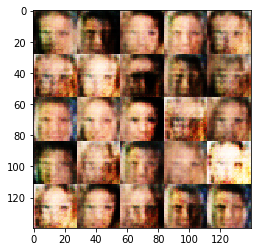

Epoch 1/1.... Batch 1310... Discriminator Loss: 1.1220.... Generator Loss: 2.5300
Epoch 1/1.... Batch 1320... Discriminator Loss: 1.1753.... Generator Loss: 0.9693
Epoch 1/1.... Batch 1330... Discriminator Loss: 0.9007.... Generator Loss: 2.1439
Epoch 1/1.... Batch 1340... Discriminator Loss: 0.8226.... Generator Loss: 1.8981
Epoch 1/1.... Batch 1350... Discriminator Loss: 0.9146.... Generator Loss: 1.5308
Epoch 1/1.... Batch 1360... Discriminator Loss: 1.0583.... Generator Loss: 1.2121
Epoch 1/1.... Batch 1370... Discriminator Loss: 0.9527.... Generator Loss: 1.3002
Epoch 1/1.... Batch 1380... Discriminator Loss: 0.9545.... Generator Loss: 1.2309
Epoch 1/1.... Batch 1390... Discriminator Loss: 0.8379.... Generator Loss: 1.7478
Epoch 1/1.... Batch 1400... Discriminator Loss: 1.8021.... Generator Loss: 0.4877


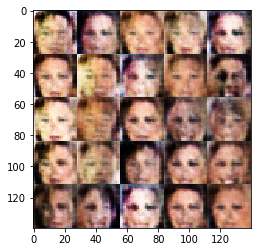

Epoch 1/1.... Batch 1410... Discriminator Loss: 1.0332.... Generator Loss: 1.6505
Epoch 1/1.... Batch 1420... Discriminator Loss: 0.8721.... Generator Loss: 2.0442
Epoch 1/1.... Batch 1430... Discriminator Loss: 0.9483.... Generator Loss: 1.3447
Epoch 1/1.... Batch 1440... Discriminator Loss: 1.5533.... Generator Loss: 3.9983
Epoch 1/1.... Batch 1450... Discriminator Loss: 1.2289.... Generator Loss: 0.8760
Epoch 1/1.... Batch 1460... Discriminator Loss: 0.9663.... Generator Loss: 2.2915
Epoch 1/1.... Batch 1470... Discriminator Loss: 1.0509.... Generator Loss: 1.4601
Epoch 1/1.... Batch 1480... Discriminator Loss: 0.8301.... Generator Loss: 1.8078
Epoch 1/1.... Batch 1490... Discriminator Loss: 0.9564.... Generator Loss: 1.6628
Epoch 1/1.... Batch 1500... Discriminator Loss: 1.5407.... Generator Loss: 3.1074


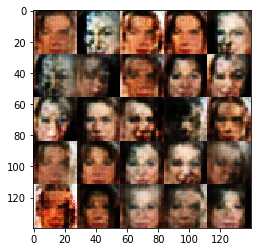

Epoch 1/1.... Batch 1510... Discriminator Loss: 0.9784.... Generator Loss: 1.4858
Epoch 1/1.... Batch 1520... Discriminator Loss: 0.9093.... Generator Loss: 1.7028
Epoch 1/1.... Batch 1530... Discriminator Loss: 1.3491.... Generator Loss: 2.9840
Epoch 1/1.... Batch 1540... Discriminator Loss: 1.4470.... Generator Loss: 3.8106
Epoch 1/1.... Batch 1550... Discriminator Loss: 1.1612.... Generator Loss: 0.9534
Epoch 1/1.... Batch 1560... Discriminator Loss: 1.0434.... Generator Loss: 1.4960
Epoch 1/1.... Batch 1570... Discriminator Loss: 0.9434.... Generator Loss: 1.7467
Epoch 1/1.... Batch 1580... Discriminator Loss: 1.1256.... Generator Loss: 1.2178
Epoch 1/1.... Batch 1590... Discriminator Loss: 0.9980.... Generator Loss: 2.0495
Epoch 1/1.... Batch 1600... Discriminator Loss: 1.0490.... Generator Loss: 1.3719


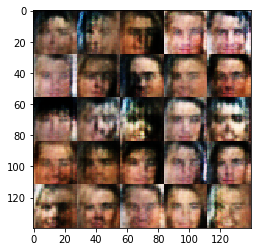

Epoch 1/1.... Batch 1610... Discriminator Loss: 1.3797.... Generator Loss: 0.7243
Epoch 1/1.... Batch 1620... Discriminator Loss: 1.1078.... Generator Loss: 1.6934
Epoch 1/1.... Batch 1630... Discriminator Loss: 1.3021.... Generator Loss: 0.8399
Epoch 1/1.... Batch 1640... Discriminator Loss: 0.9185.... Generator Loss: 1.7125
Epoch 1/1.... Batch 1650... Discriminator Loss: 1.1493.... Generator Loss: 2.4582
Epoch 1/1.... Batch 1660... Discriminator Loss: 1.3702.... Generator Loss: 0.7162
Epoch 1/1.... Batch 1670... Discriminator Loss: 1.3601.... Generator Loss: 0.7225
Epoch 1/1.... Batch 1680... Discriminator Loss: 0.9869.... Generator Loss: 1.3414
Epoch 1/1.... Batch 1690... Discriminator Loss: 0.9877.... Generator Loss: 1.7052
Epoch 1/1.... Batch 1700... Discriminator Loss: 0.9841.... Generator Loss: 1.7254


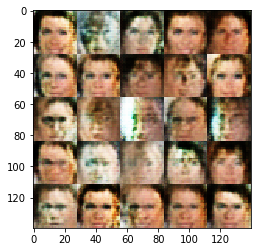

Epoch 1/1.... Batch 1710... Discriminator Loss: 1.1751.... Generator Loss: 1.1360
Epoch 1/1.... Batch 1720... Discriminator Loss: 1.2111.... Generator Loss: 0.9894
Epoch 1/1.... Batch 1730... Discriminator Loss: 1.1896.... Generator Loss: 1.1135
Epoch 1/1.... Batch 1740... Discriminator Loss: 1.3016.... Generator Loss: 0.8415
Epoch 1/1.... Batch 1750... Discriminator Loss: 1.3029.... Generator Loss: 0.8222
Epoch 1/1.... Batch 1760... Discriminator Loss: 1.0311.... Generator Loss: 1.6040
Epoch 1/1.... Batch 1770... Discriminator Loss: 0.9215.... Generator Loss: 1.6928
Epoch 1/1.... Batch 1780... Discriminator Loss: 1.0391.... Generator Loss: 1.1817
Epoch 1/1.... Batch 1790... Discriminator Loss: 0.8737.... Generator Loss: 1.9838
Epoch 1/1.... Batch 1800... Discriminator Loss: 1.2568.... Generator Loss: 1.1203


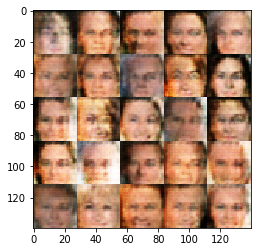

Epoch 1/1.... Batch 1810... Discriminator Loss: 1.1767.... Generator Loss: 0.9363
Epoch 1/1.... Batch 1820... Discriminator Loss: 1.2995.... Generator Loss: 0.8036
Epoch 1/1.... Batch 1830... Discriminator Loss: 1.1729.... Generator Loss: 0.8790
Epoch 1/1.... Batch 1840... Discriminator Loss: 1.2846.... Generator Loss: 0.8742
Epoch 1/1.... Batch 1850... Discriminator Loss: 1.2608.... Generator Loss: 1.0094
Epoch 1/1.... Batch 1860... Discriminator Loss: 1.0406.... Generator Loss: 1.5056
Epoch 1/1.... Batch 1870... Discriminator Loss: 1.2824.... Generator Loss: 1.4546
Epoch 1/1.... Batch 1880... Discriminator Loss: 1.1927.... Generator Loss: 0.9953
Epoch 1/1.... Batch 1890... Discriminator Loss: 1.2454.... Generator Loss: 0.8202
Epoch 1/1.... Batch 1900... Discriminator Loss: 1.2792.... Generator Loss: 1.2705


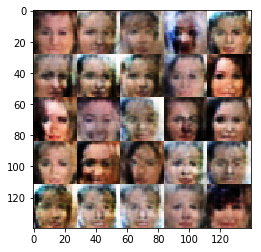

Epoch 1/1.... Batch 1910... Discriminator Loss: 1.2370.... Generator Loss: 0.8163
Epoch 1/1.... Batch 1920... Discriminator Loss: 1.3650.... Generator Loss: 2.5026
Epoch 1/1.... Batch 1930... Discriminator Loss: 1.2603.... Generator Loss: 0.7336
Epoch 1/1.... Batch 1940... Discriminator Loss: 1.1717.... Generator Loss: 2.1064
Epoch 1/1.... Batch 1950... Discriminator Loss: 1.1290.... Generator Loss: 1.0951
Epoch 1/1.... Batch 1960... Discriminator Loss: 1.1206.... Generator Loss: 1.2521
Epoch 1/1.... Batch 1970... Discriminator Loss: 1.2258.... Generator Loss: 0.8274
Epoch 1/1.... Batch 1980... Discriminator Loss: 1.1394.... Generator Loss: 1.1187
Epoch 1/1.... Batch 1990... Discriminator Loss: 1.2840.... Generator Loss: 0.7714
Epoch 1/1.... Batch 2000... Discriminator Loss: 1.2802.... Generator Loss: 0.8978


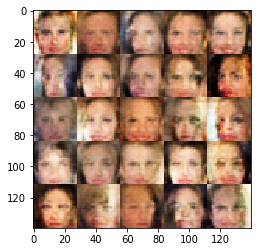

Epoch 1/1.... Batch 2010... Discriminator Loss: 1.4162.... Generator Loss: 2.9532
Epoch 1/1.... Batch 2020... Discriminator Loss: 1.1296.... Generator Loss: 1.2608
Epoch 1/1.... Batch 2030... Discriminator Loss: 1.0808.... Generator Loss: 1.1129
Epoch 1/1.... Batch 2040... Discriminator Loss: 1.1172.... Generator Loss: 1.5705
Epoch 1/1.... Batch 2050... Discriminator Loss: 1.2353.... Generator Loss: 0.7855
Epoch 1/1.... Batch 2060... Discriminator Loss: 1.0672.... Generator Loss: 1.5117
Epoch 1/1.... Batch 2070... Discriminator Loss: 1.2849.... Generator Loss: 1.4436
Epoch 1/1.... Batch 2080... Discriminator Loss: 1.2357.... Generator Loss: 0.8305
Epoch 1/1.... Batch 2090... Discriminator Loss: 0.9293.... Generator Loss: 1.3741
Epoch 1/1.... Batch 2100... Discriminator Loss: 1.3810.... Generator Loss: 2.6000


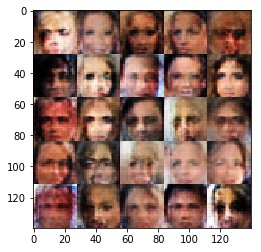

Epoch 1/1.... Batch 2110... Discriminator Loss: 1.0747.... Generator Loss: 1.1810
Epoch 1/1.... Batch 2120... Discriminator Loss: 1.4685.... Generator Loss: 0.6142
Epoch 1/1.... Batch 2130... Discriminator Loss: 1.0766.... Generator Loss: 1.0111
Epoch 1/1.... Batch 2140... Discriminator Loss: 1.2571.... Generator Loss: 0.9487
Epoch 1/1.... Batch 2150... Discriminator Loss: 1.2733.... Generator Loss: 0.9843
Epoch 1/1.... Batch 2160... Discriminator Loss: 0.9298.... Generator Loss: 1.4072
Epoch 1/1.... Batch 2170... Discriminator Loss: 1.0030.... Generator Loss: 1.4185
Epoch 1/1.... Batch 2180... Discriminator Loss: 1.2399.... Generator Loss: 0.8657
Epoch 1/1.... Batch 2190... Discriminator Loss: 1.6699.... Generator Loss: 0.4964
Epoch 1/1.... Batch 2200... Discriminator Loss: 1.2204.... Generator Loss: 0.8312


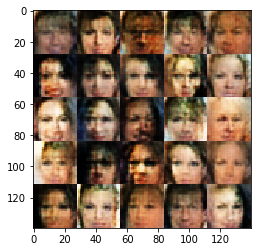

Epoch 1/1.... Batch 2210... Discriminator Loss: 1.3147.... Generator Loss: 0.9591
Epoch 1/1.... Batch 2220... Discriminator Loss: 1.4600.... Generator Loss: 0.5962
Epoch 1/1.... Batch 2230... Discriminator Loss: 1.5517.... Generator Loss: 0.5477
Epoch 1/1.... Batch 2240... Discriminator Loss: 1.1641.... Generator Loss: 0.9163
Epoch 1/1.... Batch 2250... Discriminator Loss: 1.1597.... Generator Loss: 0.9701
Epoch 1/1.... Batch 2260... Discriminator Loss: 1.0770.... Generator Loss: 1.2452
Epoch 1/1.... Batch 2270... Discriminator Loss: 1.2822.... Generator Loss: 1.7760
Epoch 1/1.... Batch 2280... Discriminator Loss: 1.0880.... Generator Loss: 2.1902
Epoch 1/1.... Batch 2290... Discriminator Loss: 1.0568.... Generator Loss: 1.4742
Epoch 1/1.... Batch 2300... Discriminator Loss: 1.1613.... Generator Loss: 0.8471


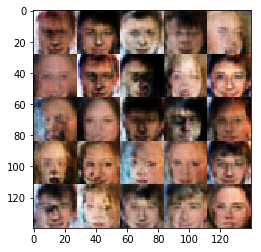

Epoch 1/1.... Batch 2310... Discriminator Loss: 1.1867.... Generator Loss: 0.9852
Epoch 1/1.... Batch 2320... Discriminator Loss: 1.0693.... Generator Loss: 1.4396
Epoch 1/1.... Batch 2330... Discriminator Loss: 1.1438.... Generator Loss: 1.1678
Epoch 1/1.... Batch 2340... Discriminator Loss: 1.0026.... Generator Loss: 1.3598
Epoch 1/1.... Batch 2350... Discriminator Loss: 1.1164.... Generator Loss: 0.9961
Epoch 1/1.... Batch 2360... Discriminator Loss: 1.1322.... Generator Loss: 1.0504
Epoch 1/1.... Batch 2370... Discriminator Loss: 1.0230.... Generator Loss: 1.3329
Epoch 1/1.... Batch 2380... Discriminator Loss: 1.3269.... Generator Loss: 0.6954
Epoch 1/1.... Batch 2390... Discriminator Loss: 1.4518.... Generator Loss: 0.5857
Epoch 1/1.... Batch 2400... Discriminator Loss: 1.0750.... Generator Loss: 1.7838


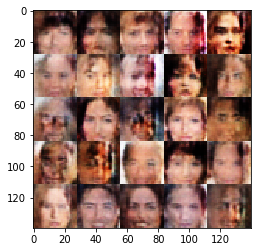

Epoch 1/1.... Batch 2410... Discriminator Loss: 1.1592.... Generator Loss: 0.9489
Epoch 1/1.... Batch 2420... Discriminator Loss: 1.1345.... Generator Loss: 1.1897
Epoch 1/1.... Batch 2430... Discriminator Loss: 1.0925.... Generator Loss: 1.4167
Epoch 1/1.... Batch 2440... Discriminator Loss: 1.1819.... Generator Loss: 0.8623
Epoch 1/1.... Batch 2450... Discriminator Loss: 1.1230.... Generator Loss: 1.3904
Epoch 1/1.... Batch 2460... Discriminator Loss: 0.9920.... Generator Loss: 1.2309
Epoch 1/1.... Batch 2470... Discriminator Loss: 1.0120.... Generator Loss: 1.5934
Epoch 1/1.... Batch 2480... Discriminator Loss: 1.6281.... Generator Loss: 2.4488
Epoch 1/1.... Batch 2490... Discriminator Loss: 1.6387.... Generator Loss: 0.4669
Epoch 1/1.... Batch 2500... Discriminator Loss: 1.1543.... Generator Loss: 1.5248


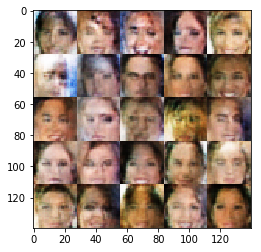

Epoch 1/1.... Batch 2510... Discriminator Loss: 1.1535.... Generator Loss: 1.1779
Epoch 1/1.... Batch 2520... Discriminator Loss: 1.1391.... Generator Loss: 1.1209
Epoch 1/1.... Batch 2530... Discriminator Loss: 1.0237.... Generator Loss: 1.4937
Epoch 1/1.... Batch 2540... Discriminator Loss: 1.2053.... Generator Loss: 0.7845
Epoch 1/1.... Batch 2550... Discriminator Loss: 1.0043.... Generator Loss: 2.0956
Epoch 1/1.... Batch 2560... Discriminator Loss: 1.2686.... Generator Loss: 0.8558
Epoch 1/1.... Batch 2570... Discriminator Loss: 1.3870.... Generator Loss: 0.6621
Epoch 1/1.... Batch 2580... Discriminator Loss: 1.1570.... Generator Loss: 0.9535
Epoch 1/1.... Batch 2590... Discriminator Loss: 1.2004.... Generator Loss: 0.9679
Epoch 1/1.... Batch 2600... Discriminator Loss: 1.1691.... Generator Loss: 1.1794


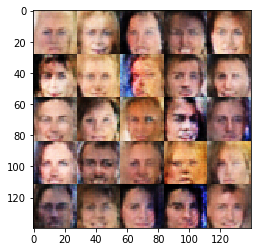

Epoch 1/1.... Batch 2610... Discriminator Loss: 1.4349.... Generator Loss: 0.6001
Epoch 1/1.... Batch 2620... Discriminator Loss: 1.5827.... Generator Loss: 0.4944
Epoch 1/1.... Batch 2630... Discriminator Loss: 1.1356.... Generator Loss: 1.0257
Epoch 1/1.... Batch 2640... Discriminator Loss: 1.1755.... Generator Loss: 0.8341
Epoch 1/1.... Batch 2650... Discriminator Loss: 1.2379.... Generator Loss: 0.7922
Epoch 1/1.... Batch 2660... Discriminator Loss: 1.1624.... Generator Loss: 1.8692
Epoch 1/1.... Batch 2670... Discriminator Loss: 1.4022.... Generator Loss: 2.2462
Epoch 1/1.... Batch 2680... Discriminator Loss: 0.9179.... Generator Loss: 2.1574
Epoch 1/1.... Batch 2690... Discriminator Loss: 1.0906.... Generator Loss: 1.1286
Epoch 1/1.... Batch 2700... Discriminator Loss: 1.3800.... Generator Loss: 0.6645


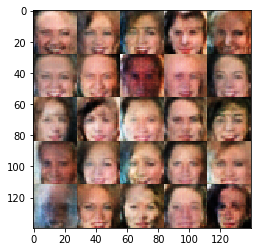

Epoch 1/1.... Batch 2710... Discriminator Loss: 1.0814.... Generator Loss: 1.0882
Epoch 1/1.... Batch 2720... Discriminator Loss: 1.1221.... Generator Loss: 1.2368
Epoch 1/1.... Batch 2730... Discriminator Loss: 1.2132.... Generator Loss: 0.8729
Epoch 1/1.... Batch 2740... Discriminator Loss: 1.1456.... Generator Loss: 1.7272
Epoch 1/1.... Batch 2750... Discriminator Loss: 1.2087.... Generator Loss: 0.9287
Epoch 1/1.... Batch 2760... Discriminator Loss: 1.2352.... Generator Loss: 0.7747
Epoch 1/1.... Batch 2770... Discriminator Loss: 1.0766.... Generator Loss: 1.7871
Epoch 1/1.... Batch 2780... Discriminator Loss: 1.0552.... Generator Loss: 1.1155
Epoch 1/1.... Batch 2790... Discriminator Loss: 1.1226.... Generator Loss: 1.1310
Epoch 1/1.... Batch 2800... Discriminator Loss: 1.1370.... Generator Loss: 1.1208


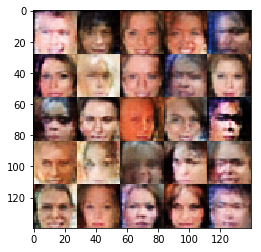

Epoch 1/1.... Batch 2810... Discriminator Loss: 1.1107.... Generator Loss: 0.9373
Epoch 1/1.... Batch 2820... Discriminator Loss: 1.2156.... Generator Loss: 0.9303
Epoch 1/1.... Batch 2830... Discriminator Loss: 1.1829.... Generator Loss: 0.8737
Epoch 1/1.... Batch 2840... Discriminator Loss: 1.0478.... Generator Loss: 2.0379
Epoch 1/1.... Batch 2850... Discriminator Loss: 1.4934.... Generator Loss: 0.5854
Epoch 1/1.... Batch 2860... Discriminator Loss: 1.1939.... Generator Loss: 0.8741
Epoch 1/1.... Batch 2870... Discriminator Loss: 1.1365.... Generator Loss: 0.9901
Epoch 1/1.... Batch 2880... Discriminator Loss: 1.5264.... Generator Loss: 0.5589
Epoch 1/1.... Batch 2890... Discriminator Loss: 1.3509.... Generator Loss: 0.7289
Epoch 1/1.... Batch 2900... Discriminator Loss: 1.0085.... Generator Loss: 1.4066


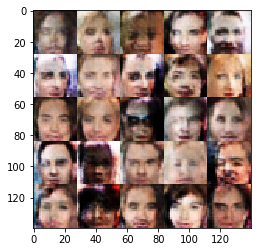

Epoch 1/1.... Batch 2910... Discriminator Loss: 1.3140.... Generator Loss: 0.7751
Epoch 1/1.... Batch 2920... Discriminator Loss: 1.1264.... Generator Loss: 1.5468
Epoch 1/1.... Batch 2930... Discriminator Loss: 0.9851.... Generator Loss: 1.4866
Epoch 1/1.... Batch 2940... Discriminator Loss: 0.9747.... Generator Loss: 1.3230
Epoch 1/1.... Batch 2950... Discriminator Loss: 1.0650.... Generator Loss: 1.1330
Epoch 1/1.... Batch 2960... Discriminator Loss: 1.0842.... Generator Loss: 1.0427
Epoch 1/1.... Batch 2970... Discriminator Loss: 1.1098.... Generator Loss: 1.3626
Epoch 1/1.... Batch 2980... Discriminator Loss: 1.2317.... Generator Loss: 0.9095
Epoch 1/1.... Batch 2990... Discriminator Loss: 1.1019.... Generator Loss: 1.0112
Epoch 1/1.... Batch 3000... Discriminator Loss: 1.3741.... Generator Loss: 0.6378


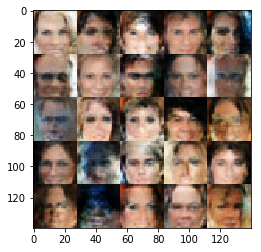

Epoch 1/1.... Batch 3010... Discriminator Loss: 1.3191.... Generator Loss: 0.8019
Epoch 1/1.... Batch 3020... Discriminator Loss: 0.9589.... Generator Loss: 1.4501
Epoch 1/1.... Batch 3030... Discriminator Loss: 0.9959.... Generator Loss: 1.1638
Epoch 1/1.... Batch 3040... Discriminator Loss: 1.1401.... Generator Loss: 1.1327
Epoch 1/1.... Batch 3050... Discriminator Loss: 1.0717.... Generator Loss: 1.6878
Epoch 1/1.... Batch 3060... Discriminator Loss: 1.0492.... Generator Loss: 1.2330
Epoch 1/1.... Batch 3070... Discriminator Loss: 1.4233.... Generator Loss: 2.1310
Epoch 1/1.... Batch 3080... Discriminator Loss: 1.3609.... Generator Loss: 0.6520
Epoch 1/1.... Batch 3090... Discriminator Loss: 1.2308.... Generator Loss: 0.8764
Epoch 1/1.... Batch 3100... Discriminator Loss: 1.1927.... Generator Loss: 0.9237


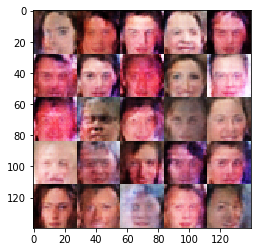

Epoch 1/1.... Batch 3110... Discriminator Loss: 1.4866.... Generator Loss: 0.5266
Epoch 1/1.... Batch 3120... Discriminator Loss: 0.9296.... Generator Loss: 1.5465
Epoch 1/1.... Batch 3130... Discriminator Loss: 1.2280.... Generator Loss: 1.1842
Epoch 1/1.... Batch 3140... Discriminator Loss: 1.1195.... Generator Loss: 1.0727
Epoch 1/1.... Batch 3150... Discriminator Loss: 1.0808.... Generator Loss: 1.1554
Epoch 1/1.... Batch 3160... Discriminator Loss: 1.1654.... Generator Loss: 1.2696
Epoch 1/1.... Batch 3170... Discriminator Loss: 1.1169.... Generator Loss: 1.0027
Epoch 1/1.... Batch 3180... Discriminator Loss: 1.5040.... Generator Loss: 0.5884
Epoch 1/1.... Batch 3190... Discriminator Loss: 1.3064.... Generator Loss: 0.7288
Epoch 1/1.... Batch 3200... Discriminator Loss: 1.0803.... Generator Loss: 1.3179


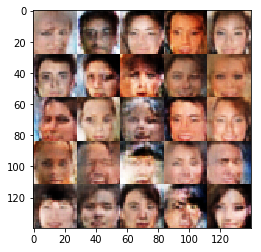

Epoch 1/1.... Batch 3210... Discriminator Loss: 1.0792.... Generator Loss: 1.3295
Epoch 1/1.... Batch 3220... Discriminator Loss: 1.0250.... Generator Loss: 1.3006
Epoch 1/1.... Batch 3230... Discriminator Loss: 1.3640.... Generator Loss: 0.6698
Epoch 1/1.... Batch 3240... Discriminator Loss: 1.0441.... Generator Loss: 1.7211
Epoch 1/1.... Batch 3250... Discriminator Loss: 1.1518.... Generator Loss: 1.2079
Epoch 1/1.... Batch 3260... Discriminator Loss: 1.1000.... Generator Loss: 2.2056
Epoch 1/1.... Batch 3270... Discriminator Loss: 1.2246.... Generator Loss: 0.9257
Epoch 1/1.... Batch 3280... Discriminator Loss: 1.0041.... Generator Loss: 1.6347
Epoch 1/1.... Batch 3290... Discriminator Loss: 1.3481.... Generator Loss: 0.7685
Epoch 1/1.... Batch 3300... Discriminator Loss: 1.0998.... Generator Loss: 1.0764


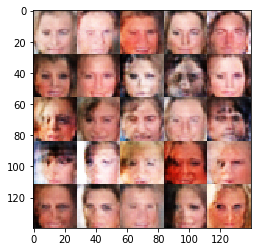

Epoch 1/1.... Batch 3310... Discriminator Loss: 1.0294.... Generator Loss: 1.3521
Epoch 1/1.... Batch 3320... Discriminator Loss: 1.5392.... Generator Loss: 0.4926
Epoch 1/1.... Batch 3330... Discriminator Loss: 1.4116.... Generator Loss: 0.5987
Epoch 1/1.... Batch 3340... Discriminator Loss: 1.2515.... Generator Loss: 0.9641
Epoch 1/1.... Batch 3350... Discriminator Loss: 1.3171.... Generator Loss: 1.4944
Epoch 1/1.... Batch 3360... Discriminator Loss: 1.4497.... Generator Loss: 0.5804
Epoch 1/1.... Batch 3370... Discriminator Loss: 1.0455.... Generator Loss: 1.2070
Epoch 1/1.... Batch 3380... Discriminator Loss: 1.1493.... Generator Loss: 1.4414
Epoch 1/1.... Batch 3390... Discriminator Loss: 1.2905.... Generator Loss: 0.7472
Epoch 1/1.... Batch 3400... Discriminator Loss: 1.9275.... Generator Loss: 0.3442


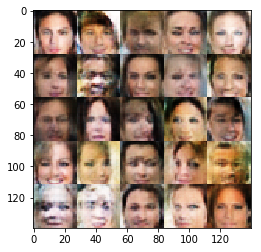

Epoch 1/1.... Batch 3410... Discriminator Loss: 1.4765.... Generator Loss: 0.6012
Epoch 1/1.... Batch 3420... Discriminator Loss: 1.0784.... Generator Loss: 1.6686
Epoch 1/1.... Batch 3430... Discriminator Loss: 1.1535.... Generator Loss: 1.1850
Epoch 1/1.... Batch 3440... Discriminator Loss: 1.3435.... Generator Loss: 2.6598
Epoch 1/1.... Batch 3450... Discriminator Loss: 1.2362.... Generator Loss: 0.8354
Epoch 1/1.... Batch 3460... Discriminator Loss: 1.1617.... Generator Loss: 1.3072
Epoch 1/1.... Batch 3470... Discriminator Loss: 1.2999.... Generator Loss: 0.6931
Epoch 1/1.... Batch 3480... Discriminator Loss: 1.1337.... Generator Loss: 1.3086
Epoch 1/1.... Batch 3490... Discriminator Loss: 1.1763.... Generator Loss: 2.0734
Epoch 1/1.... Batch 3500... Discriminator Loss: 1.1157.... Generator Loss: 0.9831


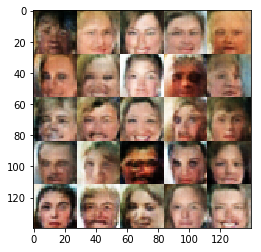

Epoch 1/1.... Batch 3510... Discriminator Loss: 1.1806.... Generator Loss: 0.8376
Epoch 1/1.... Batch 3520... Discriminator Loss: 1.5119.... Generator Loss: 0.5340
Epoch 1/1.... Batch 3530... Discriminator Loss: 1.5800.... Generator Loss: 0.4842
Epoch 1/1.... Batch 3540... Discriminator Loss: 1.0804.... Generator Loss: 1.2097
Epoch 1/1.... Batch 3550... Discriminator Loss: 1.4014.... Generator Loss: 0.6754
Epoch 1/1.... Batch 3560... Discriminator Loss: 1.4118.... Generator Loss: 0.6250
Epoch 1/1.... Batch 3570... Discriminator Loss: 1.1508.... Generator Loss: 0.9384
Epoch 1/1.... Batch 3580... Discriminator Loss: 1.2127.... Generator Loss: 1.0265
Epoch 1/1.... Batch 3590... Discriminator Loss: 0.9356.... Generator Loss: 2.1629
Epoch 1/1.... Batch 3600... Discriminator Loss: 1.3294.... Generator Loss: 0.7903


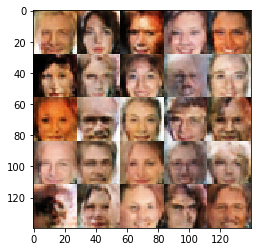

Epoch 1/1.... Batch 3610... Discriminator Loss: 1.0061.... Generator Loss: 1.4038
Epoch 1/1.... Batch 3620... Discriminator Loss: 1.1537.... Generator Loss: 1.4428
Epoch 1/1.... Batch 3630... Discriminator Loss: 1.2006.... Generator Loss: 0.8696
Epoch 1/1.... Batch 3640... Discriminator Loss: 1.3158.... Generator Loss: 0.7320
Epoch 1/1.... Batch 3650... Discriminator Loss: 1.0224.... Generator Loss: 1.2778
Epoch 1/1.... Batch 3660... Discriminator Loss: 1.0102.... Generator Loss: 1.2606
Epoch 1/1.... Batch 3670... Discriminator Loss: 1.0282.... Generator Loss: 1.1230
Epoch 1/1.... Batch 3680... Discriminator Loss: 1.4493.... Generator Loss: 0.5941
Epoch 1/1.... Batch 3690... Discriminator Loss: 1.1707.... Generator Loss: 0.9701
Epoch 1/1.... Batch 3700... Discriminator Loss: 1.2503.... Generator Loss: 0.8575


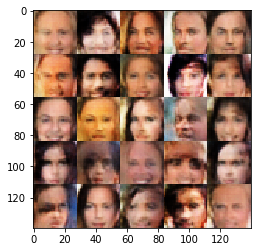

Epoch 1/1.... Batch 3710... Discriminator Loss: 1.1683.... Generator Loss: 0.9260
Epoch 1/1.... Batch 3720... Discriminator Loss: 1.1215.... Generator Loss: 1.1313
Epoch 1/1.... Batch 3730... Discriminator Loss: 1.1624.... Generator Loss: 1.0975
Epoch 1/1.... Batch 3740... Discriminator Loss: 1.4942.... Generator Loss: 0.5347
Epoch 1/1.... Batch 3750... Discriminator Loss: 1.1488.... Generator Loss: 0.9982
Epoch 1/1.... Batch 3760... Discriminator Loss: 1.2677.... Generator Loss: 0.7235
Epoch 1/1.... Batch 3770... Discriminator Loss: 1.1006.... Generator Loss: 1.0547
Epoch 1/1.... Batch 3780... Discriminator Loss: 1.2351.... Generator Loss: 1.6124
Epoch 1/1.... Batch 3790... Discriminator Loss: 1.1022.... Generator Loss: 1.0079
Epoch 1/1.... Batch 3800... Discriminator Loss: 1.3096.... Generator Loss: 0.7585


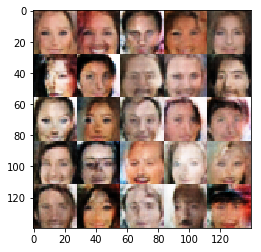

Epoch 1/1.... Batch 3810... Discriminator Loss: 1.2010.... Generator Loss: 1.0997
Epoch 1/1.... Batch 3820... Discriminator Loss: 1.2082.... Generator Loss: 1.8161
Epoch 1/1.... Batch 3830... Discriminator Loss: 1.4757.... Generator Loss: 0.5725
Epoch 1/1.... Batch 3840... Discriminator Loss: 1.2323.... Generator Loss: 0.9103
Epoch 1/1.... Batch 3850... Discriminator Loss: 1.3407.... Generator Loss: 0.7201
Epoch 1/1.... Batch 3860... Discriminator Loss: 1.0849.... Generator Loss: 1.5573
Epoch 1/1.... Batch 3870... Discriminator Loss: 1.2179.... Generator Loss: 1.1466
Epoch 1/1.... Batch 3880... Discriminator Loss: 1.0815.... Generator Loss: 1.2068
Epoch 1/1.... Batch 3890... Discriminator Loss: 1.2591.... Generator Loss: 0.7710
Epoch 1/1.... Batch 3900... Discriminator Loss: 1.1559.... Generator Loss: 1.7431


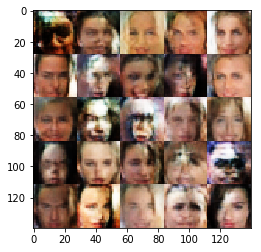

Epoch 1/1.... Batch 3910... Discriminator Loss: 1.0791.... Generator Loss: 1.2373
Epoch 1/1.... Batch 3920... Discriminator Loss: 1.0825.... Generator Loss: 1.3407
Epoch 1/1.... Batch 3930... Discriminator Loss: 1.3346.... Generator Loss: 0.6743
Epoch 1/1.... Batch 3940... Discriminator Loss: 1.1283.... Generator Loss: 0.9246
Epoch 1/1.... Batch 3950... Discriminator Loss: 1.2008.... Generator Loss: 0.8939
Epoch 1/1.... Batch 3960... Discriminator Loss: 1.0694.... Generator Loss: 1.0702
Epoch 1/1.... Batch 3970... Discriminator Loss: 1.3922.... Generator Loss: 0.5808
Epoch 1/1.... Batch 3980... Discriminator Loss: 1.0232.... Generator Loss: 1.9085
Epoch 1/1.... Batch 3990... Discriminator Loss: 1.5102.... Generator Loss: 0.5523
Epoch 1/1.... Batch 4000... Discriminator Loss: 1.2922.... Generator Loss: 1.8677


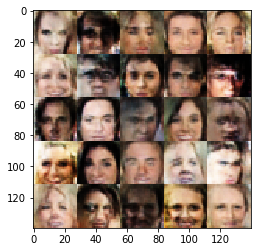

Epoch 1/1.... Batch 4010... Discriminator Loss: 1.5251.... Generator Loss: 0.5097
Epoch 1/1.... Batch 4020... Discriminator Loss: 1.2938.... Generator Loss: 0.7658
Epoch 1/1.... Batch 4030... Discriminator Loss: 1.2569.... Generator Loss: 1.1539
Epoch 1/1.... Batch 4040... Discriminator Loss: 1.1945.... Generator Loss: 0.8892
Epoch 1/1.... Batch 4050... Discriminator Loss: 1.2185.... Generator Loss: 1.1483
Epoch 1/1.... Batch 4060... Discriminator Loss: 1.7082.... Generator Loss: 0.4262
Epoch 1/1.... Batch 4070... Discriminator Loss: 0.9576.... Generator Loss: 1.8796
Epoch 1/1.... Batch 4080... Discriminator Loss: 1.1291.... Generator Loss: 1.1637
Epoch 1/1.... Batch 4090... Discriminator Loss: 1.1807.... Generator Loss: 1.6865
Epoch 1/1.... Batch 4100... Discriminator Loss: 1.1817.... Generator Loss: 0.8769


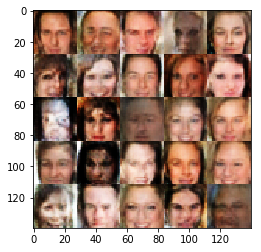

Epoch 1/1.... Batch 4110... Discriminator Loss: 1.1199.... Generator Loss: 1.1452
Epoch 1/1.... Batch 4120... Discriminator Loss: 1.1656.... Generator Loss: 0.9555
Epoch 1/1.... Batch 4130... Discriminator Loss: 1.1084.... Generator Loss: 1.4724
Epoch 1/1.... Batch 4140... Discriminator Loss: 1.0870.... Generator Loss: 1.0996
Epoch 1/1.... Batch 4150... Discriminator Loss: 1.2935.... Generator Loss: 0.6702
Epoch 1/1.... Batch 4160... Discriminator Loss: 1.1780.... Generator Loss: 0.8702
Epoch 1/1.... Batch 4170... Discriminator Loss: 1.2714.... Generator Loss: 0.7658
Epoch 1/1.... Batch 4180... Discriminator Loss: 1.0442.... Generator Loss: 1.0989
Epoch 1/1.... Batch 4190... Discriminator Loss: 1.0897.... Generator Loss: 1.1026
Epoch 1/1.... Batch 4200... Discriminator Loss: 1.3051.... Generator Loss: 0.7188


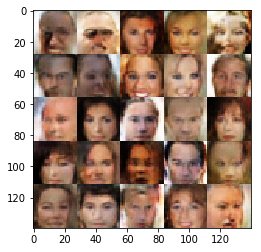

Epoch 1/1.... Batch 4210... Discriminator Loss: 1.4020.... Generator Loss: 0.6355
Epoch 1/1.... Batch 4220... Discriminator Loss: 1.3004.... Generator Loss: 0.7487
Epoch 1/1.... Batch 4230... Discriminator Loss: 1.2476.... Generator Loss: 0.9600
Epoch 1/1.... Batch 4240... Discriminator Loss: 1.3072.... Generator Loss: 0.7290
Epoch 1/1.... Batch 4250... Discriminator Loss: 1.3709.... Generator Loss: 0.7882
Epoch 1/1.... Batch 4260... Discriminator Loss: 1.1084.... Generator Loss: 1.3554
Epoch 1/1.... Batch 4270... Discriminator Loss: 1.5535.... Generator Loss: 0.5062
Epoch 1/1.... Batch 4280... Discriminator Loss: 1.3427.... Generator Loss: 0.7047
Epoch 1/1.... Batch 4290... Discriminator Loss: 1.1635.... Generator Loss: 1.6130
Epoch 1/1.... Batch 4300... Discriminator Loss: 1.2954.... Generator Loss: 0.6960


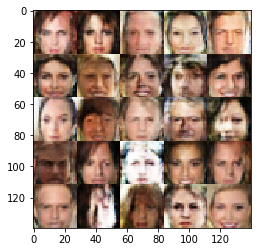

Epoch 1/1.... Batch 4310... Discriminator Loss: 1.3232.... Generator Loss: 0.7678
Epoch 1/1.... Batch 4320... Discriminator Loss: 1.1004.... Generator Loss: 1.1292
Epoch 1/1.... Batch 4330... Discriminator Loss: 1.2110.... Generator Loss: 1.0186
Epoch 1/1.... Batch 4340... Discriminator Loss: 1.2581.... Generator Loss: 0.7353
Epoch 1/1.... Batch 4350... Discriminator Loss: 1.4577.... Generator Loss: 0.5939
Epoch 1/1.... Batch 4360... Discriminator Loss: 1.1104.... Generator Loss: 1.6888
Epoch 1/1.... Batch 4370... Discriminator Loss: 1.0586.... Generator Loss: 1.4185
Epoch 1/1.... Batch 4380... Discriminator Loss: 1.1588.... Generator Loss: 0.9618
Epoch 1/1.... Batch 4390... Discriminator Loss: 1.3358.... Generator Loss: 0.7002
Epoch 1/1.... Batch 4400... Discriminator Loss: 1.2625.... Generator Loss: 0.9585


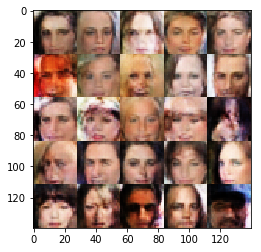

Epoch 1/1.... Batch 4410... Discriminator Loss: 1.3199.... Generator Loss: 1.8304
Epoch 1/1.... Batch 4420... Discriminator Loss: 1.1608.... Generator Loss: 0.9862
Epoch 1/1.... Batch 4430... Discriminator Loss: 1.5305.... Generator Loss: 0.5172
Epoch 1/1.... Batch 4440... Discriminator Loss: 1.0603.... Generator Loss: 1.1954
Epoch 1/1.... Batch 4450... Discriminator Loss: 1.3270.... Generator Loss: 0.7333
Epoch 1/1.... Batch 4460... Discriminator Loss: 1.3384.... Generator Loss: 0.7812
Epoch 1/1.... Batch 4470... Discriminator Loss: 1.0895.... Generator Loss: 1.0446
Epoch 1/1.... Batch 4480... Discriminator Loss: 1.0633.... Generator Loss: 1.5366
Epoch 1/1.... Batch 4490... Discriminator Loss: 1.1702.... Generator Loss: 0.8972
Epoch 1/1.... Batch 4500... Discriminator Loss: 1.2719.... Generator Loss: 0.8026


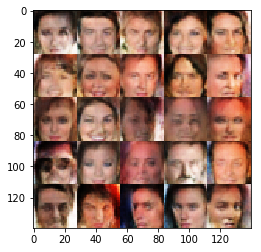

Epoch 1/1.... Batch 4510... Discriminator Loss: 1.0166.... Generator Loss: 1.3845
Epoch 1/1.... Batch 4520... Discriminator Loss: 1.3526.... Generator Loss: 0.7474
Epoch 1/1.... Batch 4530... Discriminator Loss: 1.2554.... Generator Loss: 0.9183
Epoch 1/1.... Batch 4540... Discriminator Loss: 1.0066.... Generator Loss: 1.2821
Epoch 1/1.... Batch 4550... Discriminator Loss: 1.1313.... Generator Loss: 1.0189
Epoch 1/1.... Batch 4560... Discriminator Loss: 1.1170.... Generator Loss: 1.2782
Epoch 1/1.... Batch 4570... Discriminator Loss: 1.2368.... Generator Loss: 1.0429
Epoch 1/1.... Batch 4580... Discriminator Loss: 1.4121.... Generator Loss: 0.6031
Epoch 1/1.... Batch 4590... Discriminator Loss: 1.1651.... Generator Loss: 0.9676
Epoch 1/1.... Batch 4600... Discriminator Loss: 1.1878.... Generator Loss: 0.9195


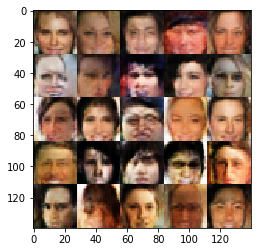

Epoch 1/1.... Batch 4610... Discriminator Loss: 1.1889.... Generator Loss: 1.5622
Epoch 1/1.... Batch 4620... Discriminator Loss: 1.1266.... Generator Loss: 1.1257
Epoch 1/1.... Batch 4630... Discriminator Loss: 1.2311.... Generator Loss: 0.7788
Epoch 1/1.... Batch 4640... Discriminator Loss: 1.3339.... Generator Loss: 0.7326
Epoch 1/1.... Batch 4650... Discriminator Loss: 1.3194.... Generator Loss: 0.7166
Epoch 1/1.... Batch 4660... Discriminator Loss: 1.2561.... Generator Loss: 0.8477
Epoch 1/1.... Batch 4670... Discriminator Loss: 1.2222.... Generator Loss: 0.8716
Epoch 1/1.... Batch 4680... Discriminator Loss: 1.0845.... Generator Loss: 1.0325
Epoch 1/1.... Batch 4690... Discriminator Loss: 0.9838.... Generator Loss: 1.8917
Epoch 1/1.... Batch 4700... Discriminator Loss: 1.1771.... Generator Loss: 1.2392


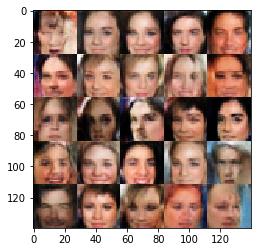

Epoch 1/1.... Batch 4710... Discriminator Loss: 1.2122.... Generator Loss: 1.4537
Epoch 1/1.... Batch 4720... Discriminator Loss: 1.0591.... Generator Loss: 1.2922
Epoch 1/1.... Batch 4730... Discriminator Loss: 1.2106.... Generator Loss: 1.1070
Epoch 1/1.... Batch 4740... Discriminator Loss: 1.1056.... Generator Loss: 1.6905
Epoch 1/1.... Batch 4750... Discriminator Loss: 1.1616.... Generator Loss: 0.9543
Epoch 1/1.... Batch 4760... Discriminator Loss: 1.1336.... Generator Loss: 1.1556
Epoch 1/1.... Batch 4770... Discriminator Loss: 1.1936.... Generator Loss: 0.9253
Epoch 1/1.... Batch 4780... Discriminator Loss: 1.1176.... Generator Loss: 1.3450
Epoch 1/1.... Batch 4790... Discriminator Loss: 1.2523.... Generator Loss: 0.8411
Epoch 1/1.... Batch 4800... Discriminator Loss: 1.1276.... Generator Loss: 1.1758


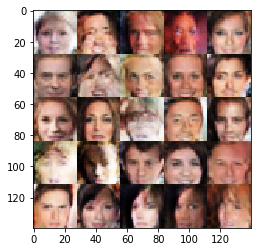

Epoch 1/1.... Batch 4810... Discriminator Loss: 1.1909.... Generator Loss: 0.9267
Epoch 1/1.... Batch 4820... Discriminator Loss: 1.1829.... Generator Loss: 0.8455
Epoch 1/1.... Batch 4830... Discriminator Loss: 1.5710.... Generator Loss: 0.5385
Epoch 1/1.... Batch 4840... Discriminator Loss: 1.1168.... Generator Loss: 1.0776
Epoch 1/1.... Batch 4850... Discriminator Loss: 1.1883.... Generator Loss: 0.8794
Epoch 1/1.... Batch 4860... Discriminator Loss: 1.3981.... Generator Loss: 0.6222
Epoch 1/1.... Batch 4870... Discriminator Loss: 1.1121.... Generator Loss: 1.1832
Epoch 1/1.... Batch 4880... Discriminator Loss: 1.1952.... Generator Loss: 1.1275
Epoch 1/1.... Batch 4890... Discriminator Loss: 1.2214.... Generator Loss: 0.8241
Epoch 1/1.... Batch 4900... Discriminator Loss: 1.1338.... Generator Loss: 1.1493


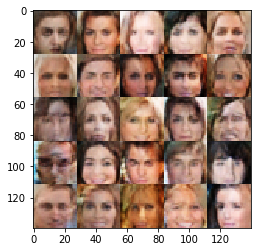

Epoch 1/1.... Batch 4910... Discriminator Loss: 1.3904.... Generator Loss: 0.6085
Epoch 1/1.... Batch 4920... Discriminator Loss: 1.3626.... Generator Loss: 0.6917
Epoch 1/1.... Batch 4930... Discriminator Loss: 1.6098.... Generator Loss: 2.4250
Epoch 1/1.... Batch 4940... Discriminator Loss: 1.2673.... Generator Loss: 0.7486
Epoch 1/1.... Batch 4950... Discriminator Loss: 1.1984.... Generator Loss: 0.9448
Epoch 1/1.... Batch 4960... Discriminator Loss: 1.2843.... Generator Loss: 0.7299
Epoch 1/1.... Batch 4970... Discriminator Loss: 1.1025.... Generator Loss: 1.1166
Epoch 1/1.... Batch 4980... Discriminator Loss: 1.6659.... Generator Loss: 0.4206
Epoch 1/1.... Batch 4990... Discriminator Loss: 1.0603.... Generator Loss: 1.6280
Epoch 1/1.... Batch 5000... Discriminator Loss: 1.4655.... Generator Loss: 0.5538


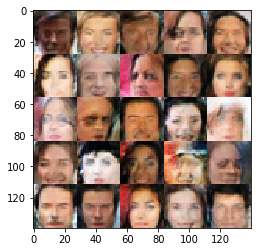

Epoch 1/1.... Batch 5010... Discriminator Loss: 1.1647.... Generator Loss: 1.1348
Epoch 1/1.... Batch 5020... Discriminator Loss: 1.2347.... Generator Loss: 0.8262
Epoch 1/1.... Batch 5030... Discriminator Loss: 1.1553.... Generator Loss: 0.9015
Epoch 1/1.... Batch 5040... Discriminator Loss: 1.1907.... Generator Loss: 0.9139
Epoch 1/1.... Batch 5050... Discriminator Loss: 1.1678.... Generator Loss: 1.1913
Epoch 1/1.... Batch 5060... Discriminator Loss: 1.0357.... Generator Loss: 1.2336
Epoch 1/1.... Batch 5070... Discriminator Loss: 1.1747.... Generator Loss: 1.0719
Epoch 1/1.... Batch 5080... Discriminator Loss: 1.7764.... Generator Loss: 0.3913
Epoch 1/1.... Batch 5090... Discriminator Loss: 1.4409.... Generator Loss: 0.6142
Epoch 1/1.... Batch 5100... Discriminator Loss: 1.2025.... Generator Loss: 0.8227


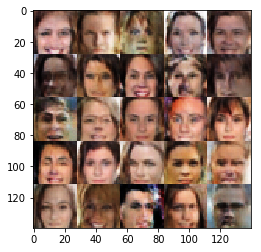

Epoch 1/1.... Batch 5110... Discriminator Loss: 1.0427.... Generator Loss: 1.3556
Epoch 1/1.... Batch 5120... Discriminator Loss: 1.6373.... Generator Loss: 0.4642
Epoch 1/1.... Batch 5130... Discriminator Loss: 1.3539.... Generator Loss: 0.6354
Epoch 1/1.... Batch 5140... Discriminator Loss: 1.2901.... Generator Loss: 0.8822
Epoch 1/1.... Batch 5150... Discriminator Loss: 1.2574.... Generator Loss: 0.7650
Epoch 1/1.... Batch 5160... Discriminator Loss: 1.1811.... Generator Loss: 0.8992
Epoch 1/1.... Batch 5170... Discriminator Loss: 1.1293.... Generator Loss: 1.4114
Epoch 1/1.... Batch 5180... Discriminator Loss: 1.1688.... Generator Loss: 1.3532
Epoch 1/1.... Batch 5190... Discriminator Loss: 1.5930.... Generator Loss: 0.4687
Epoch 1/1.... Batch 5200... Discriminator Loss: 1.2799.... Generator Loss: 0.8817


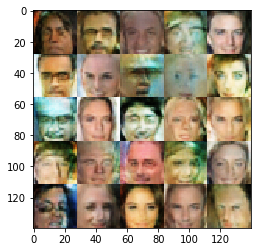

Epoch 1/1.... Batch 5210... Discriminator Loss: 1.2852.... Generator Loss: 0.7579
Epoch 1/1.... Batch 5220... Discriminator Loss: 1.0538.... Generator Loss: 1.0904
Epoch 1/1.... Batch 5230... Discriminator Loss: 1.4847.... Generator Loss: 0.5473
Epoch 1/1.... Batch 5240... Discriminator Loss: 1.1254.... Generator Loss: 1.4639
Epoch 1/1.... Batch 5250... Discriminator Loss: 1.3932.... Generator Loss: 1.7774
Epoch 1/1.... Batch 5260... Discriminator Loss: 1.3342.... Generator Loss: 0.6983
Epoch 1/1.... Batch 5270... Discriminator Loss: 1.1443.... Generator Loss: 1.6087
Epoch 1/1.... Batch 5280... Discriminator Loss: 1.0675.... Generator Loss: 1.0766
Epoch 1/1.... Batch 5290... Discriminator Loss: 1.2258.... Generator Loss: 1.5837
Epoch 1/1.... Batch 5300... Discriminator Loss: 0.9616.... Generator Loss: 1.4998


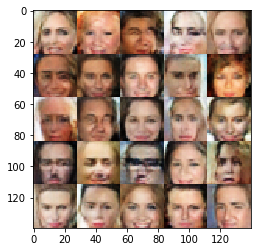

Epoch 1/1.... Batch 5310... Discriminator Loss: 1.0827.... Generator Loss: 1.2626
Epoch 1/1.... Batch 5320... Discriminator Loss: 1.4785.... Generator Loss: 0.5626
Epoch 1/1.... Batch 5330... Discriminator Loss: 1.5147.... Generator Loss: 0.5464
Epoch 1/1.... Batch 5340... Discriminator Loss: 1.0595.... Generator Loss: 1.1928
Epoch 1/1.... Batch 5350... Discriminator Loss: 1.4450.... Generator Loss: 0.5916
Epoch 1/1.... Batch 5360... Discriminator Loss: 1.1520.... Generator Loss: 1.0445
Epoch 1/1.... Batch 5370... Discriminator Loss: 1.3242.... Generator Loss: 0.7124
Epoch 1/1.... Batch 5380... Discriminator Loss: 1.3751.... Generator Loss: 1.2161
Epoch 1/1.... Batch 5390... Discriminator Loss: 1.3322.... Generator Loss: 0.7180
Epoch 1/1.... Batch 5400... Discriminator Loss: 1.5188.... Generator Loss: 0.5217


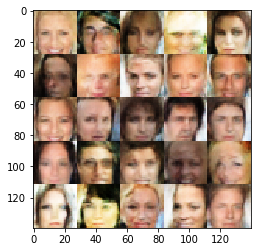

Epoch 1/1.... Batch 5410... Discriminator Loss: 1.3362.... Generator Loss: 0.6549
Epoch 1/1.... Batch 5420... Discriminator Loss: 1.2533.... Generator Loss: 1.1477
Epoch 1/1.... Batch 5430... Discriminator Loss: 1.5303.... Generator Loss: 0.5220
Epoch 1/1.... Batch 5440... Discriminator Loss: 1.2901.... Generator Loss: 0.8825
Epoch 1/1.... Batch 5450... Discriminator Loss: 1.3291.... Generator Loss: 0.6813
Epoch 1/1.... Batch 5460... Discriminator Loss: 1.2229.... Generator Loss: 0.9083
Epoch 1/1.... Batch 5470... Discriminator Loss: 1.0646.... Generator Loss: 1.2312
Epoch 1/1.... Batch 5480... Discriminator Loss: 1.1304.... Generator Loss: 1.0491
Epoch 1/1.... Batch 5490... Discriminator Loss: 1.5918.... Generator Loss: 0.4823
Epoch 1/1.... Batch 5500... Discriminator Loss: 1.3736.... Generator Loss: 0.6279


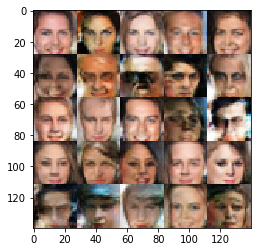

Epoch 1/1.... Batch 5510... Discriminator Loss: 1.3811.... Generator Loss: 0.6638
Epoch 1/1.... Batch 5520... Discriminator Loss: 1.0750.... Generator Loss: 1.1797
Epoch 1/1.... Batch 5530... Discriminator Loss: 1.0614.... Generator Loss: 1.1650
Epoch 1/1.... Batch 5540... Discriminator Loss: 1.1899.... Generator Loss: 0.9833
Epoch 1/1.... Batch 5550... Discriminator Loss: 1.3181.... Generator Loss: 0.7510
Epoch 1/1.... Batch 5560... Discriminator Loss: 1.2930.... Generator Loss: 0.8565
Epoch 1/1.... Batch 5570... Discriminator Loss: 1.2276.... Generator Loss: 0.7610
Epoch 1/1.... Batch 5580... Discriminator Loss: 1.3954.... Generator Loss: 0.6062
Epoch 1/1.... Batch 5590... Discriminator Loss: 1.6771.... Generator Loss: 0.4713
Epoch 1/1.... Batch 5600... Discriminator Loss: 1.5946.... Generator Loss: 0.4819


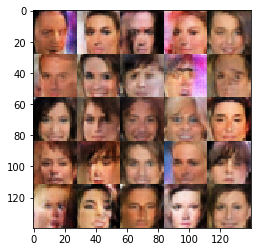

Epoch 1/1.... Batch 5610... Discriminator Loss: 1.1931.... Generator Loss: 0.8649
Epoch 1/1.... Batch 5620... Discriminator Loss: 0.9923.... Generator Loss: 1.2933
Epoch 1/1.... Batch 5630... Discriminator Loss: 1.3349.... Generator Loss: 0.7072
Epoch 1/1.... Batch 5640... Discriminator Loss: 1.1646.... Generator Loss: 1.0343
Epoch 1/1.... Batch 5650... Discriminator Loss: 1.4061.... Generator Loss: 0.6050
Epoch 1/1.... Batch 5660... Discriminator Loss: 1.3788.... Generator Loss: 0.6938
Epoch 1/1.... Batch 5670... Discriminator Loss: 1.3318.... Generator Loss: 0.7430
Epoch 1/1.... Batch 5680... Discriminator Loss: 1.3209.... Generator Loss: 0.6773
Epoch 1/1.... Batch 5690... Discriminator Loss: 1.2550.... Generator Loss: 0.7267
Epoch 1/1.... Batch 5700... Discriminator Loss: 1.3464.... Generator Loss: 0.7765


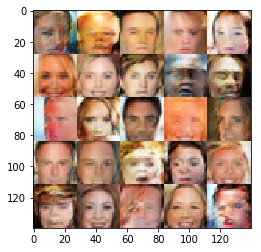

Epoch 1/1.... Batch 5710... Discriminator Loss: 1.1844.... Generator Loss: 1.7172
Epoch 1/1.... Batch 5720... Discriminator Loss: 1.0347.... Generator Loss: 1.1886
Epoch 1/1.... Batch 5730... Discriminator Loss: 1.1635.... Generator Loss: 0.9748
Epoch 1/1.... Batch 5740... Discriminator Loss: 1.2987.... Generator Loss: 0.9525
Epoch 1/1.... Batch 5750... Discriminator Loss: 1.1841.... Generator Loss: 0.9414
Epoch 1/1.... Batch 5760... Discriminator Loss: 0.9714.... Generator Loss: 1.5243
Epoch 1/1.... Batch 5770... Discriminator Loss: 1.2298.... Generator Loss: 0.8032
Epoch 1/1.... Batch 5780... Discriminator Loss: 1.1736.... Generator Loss: 1.1615
Epoch 1/1.... Batch 5790... Discriminator Loss: 1.3581.... Generator Loss: 0.6434
Epoch 1/1.... Batch 5800... Discriminator Loss: 1.4404.... Generator Loss: 0.6409


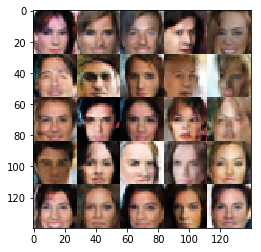

Epoch 1/1.... Batch 5810... Discriminator Loss: 1.0848.... Generator Loss: 1.1149
Epoch 1/1.... Batch 5820... Discriminator Loss: 1.2528.... Generator Loss: 0.7595
Epoch 1/1.... Batch 5830... Discriminator Loss: 1.5166.... Generator Loss: 0.5795
Epoch 1/1.... Batch 5840... Discriminator Loss: 1.0878.... Generator Loss: 1.3434
Epoch 1/1.... Batch 5850... Discriminator Loss: 1.1781.... Generator Loss: 0.9546
Epoch 1/1.... Batch 5860... Discriminator Loss: 1.3349.... Generator Loss: 1.1613
Epoch 1/1.... Batch 5870... Discriminator Loss: 1.3606.... Generator Loss: 0.7386
Epoch 1/1.... Batch 5880... Discriminator Loss: 1.3348.... Generator Loss: 0.6963
Epoch 1/1.... Batch 5890... Discriminator Loss: 1.1773.... Generator Loss: 0.9809
Epoch 1/1.... Batch 5900... Discriminator Loss: 1.1990.... Generator Loss: 0.9451


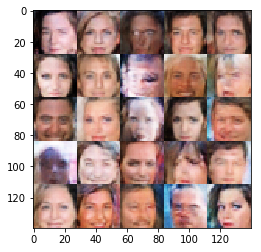

Epoch 1/1.... Batch 5910... Discriminator Loss: 1.3135.... Generator Loss: 0.7214
Epoch 1/1.... Batch 5920... Discriminator Loss: 1.1298.... Generator Loss: 1.0579
Epoch 1/1.... Batch 5930... Discriminator Loss: 1.2823.... Generator Loss: 0.8018
Epoch 1/1.... Batch 5940... Discriminator Loss: 1.0342.... Generator Loss: 1.1117
Epoch 1/1.... Batch 5950... Discriminator Loss: 0.9967.... Generator Loss: 1.1508
Epoch 1/1.... Batch 5960... Discriminator Loss: 1.6441.... Generator Loss: 0.4440
Epoch 1/1.... Batch 5970... Discriminator Loss: 1.2758.... Generator Loss: 0.7908
Epoch 1/1.... Batch 5980... Discriminator Loss: 1.3565.... Generator Loss: 0.7258
Epoch 1/1.... Batch 5990... Discriminator Loss: 1.0934.... Generator Loss: 1.7847
Epoch 1/1.... Batch 6000... Discriminator Loss: 1.2719.... Generator Loss: 0.8373


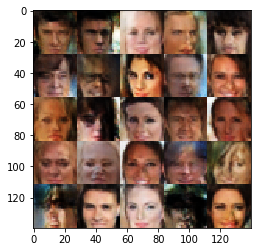

Epoch 1/1.... Batch 6010... Discriminator Loss: 1.1986.... Generator Loss: 1.7033
Epoch 1/1.... Batch 6020... Discriminator Loss: 1.2759.... Generator Loss: 0.8171
Epoch 1/1.... Batch 6030... Discriminator Loss: 1.6385.... Generator Loss: 0.4539
Epoch 1/1.... Batch 6040... Discriminator Loss: 1.0424.... Generator Loss: 1.3014
Epoch 1/1.... Batch 6050... Discriminator Loss: 1.6316.... Generator Loss: 0.4464
Epoch 1/1.... Batch 6060... Discriminator Loss: 1.2702.... Generator Loss: 0.8042
Epoch 1/1.... Batch 6070... Discriminator Loss: 1.0457.... Generator Loss: 1.2852
Epoch 1/1.... Batch 6080... Discriminator Loss: 1.2650.... Generator Loss: 0.7471
Epoch 1/1.... Batch 6090... Discriminator Loss: 1.3377.... Generator Loss: 0.6827
Epoch 1/1.... Batch 6100... Discriminator Loss: 1.0739.... Generator Loss: 1.4777


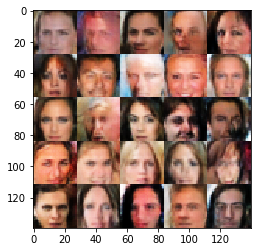

Epoch 1/1.... Batch 6110... Discriminator Loss: 1.0829.... Generator Loss: 1.0966
Epoch 1/1.... Batch 6120... Discriminator Loss: 1.1059.... Generator Loss: 0.9848
Epoch 1/1.... Batch 6130... Discriminator Loss: 1.0461.... Generator Loss: 1.0298
Epoch 1/1.... Batch 6140... Discriminator Loss: 1.3860.... Generator Loss: 0.5951
Epoch 1/1.... Batch 6150... Discriminator Loss: 1.7582.... Generator Loss: 0.3945
Epoch 1/1.... Batch 6160... Discriminator Loss: 1.1395.... Generator Loss: 1.3829
Epoch 1/1.... Batch 6170... Discriminator Loss: 1.1991.... Generator Loss: 1.0011
Epoch 1/1.... Batch 6180... Discriminator Loss: 1.4663.... Generator Loss: 0.5866
Epoch 1/1.... Batch 6190... Discriminator Loss: 0.9961.... Generator Loss: 1.1470
Epoch 1/1.... Batch 6200... Discriminator Loss: 1.1388.... Generator Loss: 0.9452


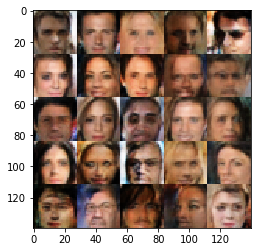

Epoch 1/1.... Batch 6210... Discriminator Loss: 1.0107.... Generator Loss: 1.5958
Epoch 1/1.... Batch 6220... Discriminator Loss: 1.3138.... Generator Loss: 0.7259
Epoch 1/1.... Batch 6230... Discriminator Loss: 1.8571.... Generator Loss: 0.3390
Epoch 1/1.... Batch 6240... Discriminator Loss: 1.1636.... Generator Loss: 1.0246
Epoch 1/1.... Batch 6250... Discriminator Loss: 1.0710.... Generator Loss: 1.1638
Epoch 1/1.... Batch 6260... Discriminator Loss: 1.2257.... Generator Loss: 0.8155
Epoch 1/1.... Batch 6270... Discriminator Loss: 1.5659.... Generator Loss: 0.4935
Epoch 1/1.... Batch 6280... Discriminator Loss: 1.7138.... Generator Loss: 0.4133
Epoch 1/1.... Batch 6290... Discriminator Loss: 0.8557.... Generator Loss: 1.7222
Epoch 1/1.... Batch 6300... Discriminator Loss: 1.2852.... Generator Loss: 0.7479


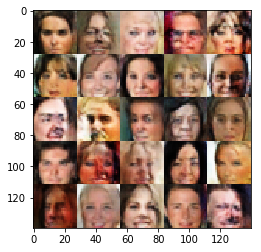

Epoch 1/1.... Batch 6310... Discriminator Loss: 1.1873.... Generator Loss: 0.8834
Epoch 1/1.... Batch 6320... Discriminator Loss: 1.0582.... Generator Loss: 1.5187
Epoch 1/1.... Batch 6330... Discriminator Loss: 1.1207.... Generator Loss: 1.1402


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.